# Time Series Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import math
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.mlab as mlab
import math
from scipy.stats import norm
import statsmodels.graphics.tsaplots as tsa
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%config InlineBackend.figure_format = 'retina'

# Données “Syndromes grippaux” 

1) Importez les données du fichier Openhealth_S-Grippal.csv. Consultez http://www.openhealth. fr/ias pour plus d’information sur les données. Affichez les 5 premières lignes du jeu de données. On va travailler seulement avec la variable IAS_brut, sous la forme d’une série temporelle, dont on précisera la fréquence d’échantillonage et les dates de début et de fin. Pour cette variable, dans ce jeu de données, les cas de nullité correspondent à des données manquantes. Combiende données manquantes comporte-t-elle? Pour les traitements des questions suivantes, éliminez les données manquantes par imputation, c’est-à-dire en déduisant une valeur plus “raisonnable” aux dates non- observées à partir des valeurs aux dates observées : par exemple par la moyenne de deux dates les plus proches.

In [2]:
df = pd.read_csv("OpenhealthS-Grippal.csv", delimiter=";",
                 encoding="latin-1", decimal=",", na_values=0)

In [3]:
df.tail()

PERIODE  IAS_brut  IAS_lisse  Incidence_Sentinelles
1747  2014-04-13      77.9        1.8                    NaN
1748  2014-04-14       2.7        1.7                    NaN
1749  2014-04-15       1.0        1.6                    NaN
1750  2014-04-16       1.6        1.6                    NaN
1751  2014-04-17       0.4        1.6                    NaN

In [4]:
df.describe()

IAS_brut    IAS_lisse  Incidence_Sentinelles
count   1744.000000  1752.000000            1734.000000
mean     316.680046    34.805023              13.536332
std     2752.169290   101.589259              22.547233
min        0.100000     0.300000               0.100000
25%        1.300000     1.200000               1.100000
50%        3.800000     2.850000               3.600000
75%       23.275000    11.400000              13.350000
max    71851.800000   863.100000             110.000000

In [5]:
df['IAS_brut'].isnull().sum()

8

Il y a 8 valeurs manquantes.

In [7]:
#On choisi l'interpolation linéaire  pour les valeurs manquantes.
df['IAS_brut'] = df['IAS_brut'].interpolate(method='linear',axis=0)

2. Tracez la série temporelle considérée en fonction du temps. Commentez brièvement ce que vous observez.

In [8]:
#transform to datastamps
df['PERIODE'] = pd.to_datetime(df['PERIODE'])

In [9]:
type(df['PERIODE'])

pandas.core.series.Series

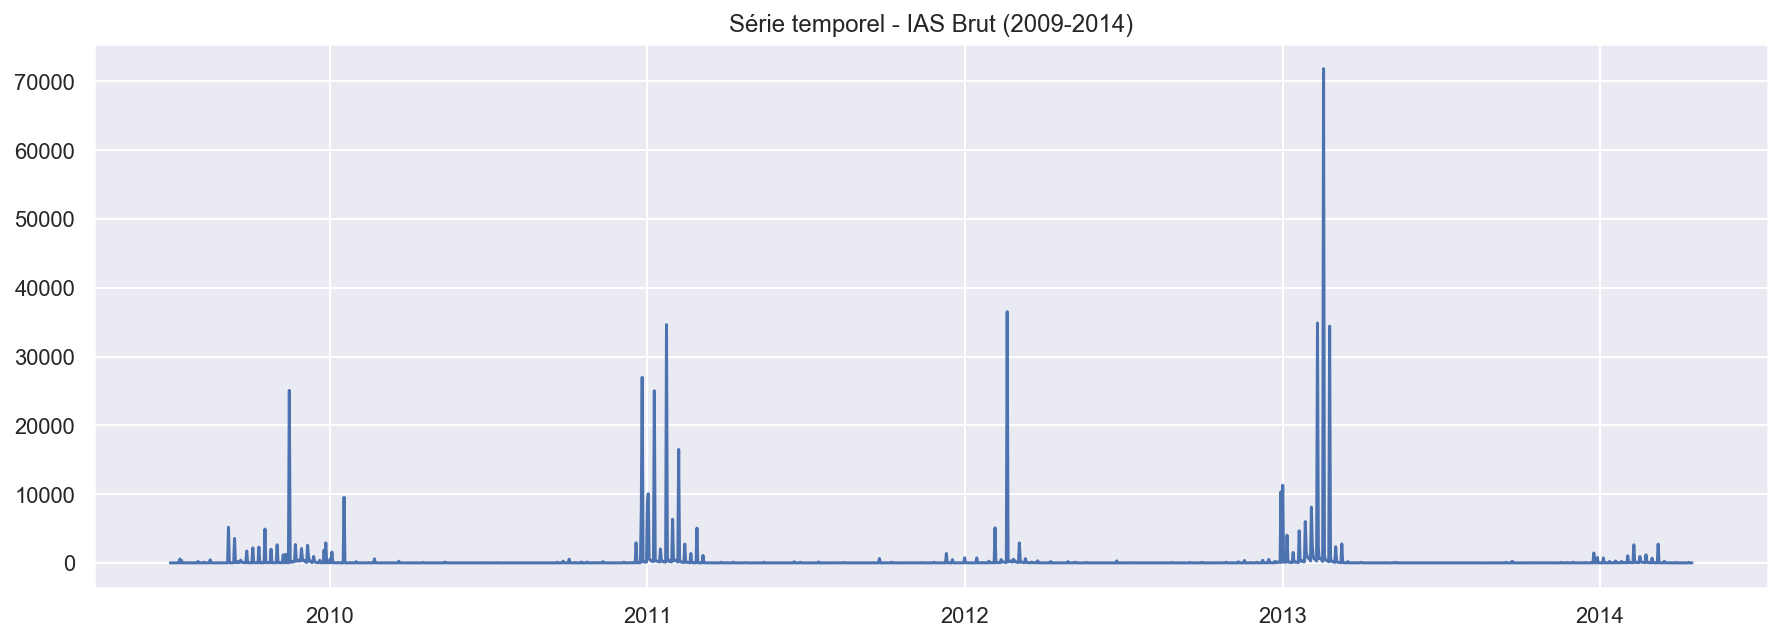

In [10]:
sns.set()
plt.figure(figsize=(15, 5))
plt.plot(df['PERIODE'].values, df['IAS_brut'].values)
plt.title("Série temporel - IAS Brut (2009-2014)")
plt.show()

<font style="color:Royalblue"> 
Il y a une périodité annuelle(sans doute lié avec le pic d'épidemie de la grippe en hiver). Cependant, le pic est moins prononcée pour 2014.


3. Tracez l’histogramme de la loi marginale. Quel impact la distribution observée par l’histogramme
a sur la trajectoire représentée à la question précédente ?

Text(0.5, 1.0, 'Histogramme de IAS Brut')

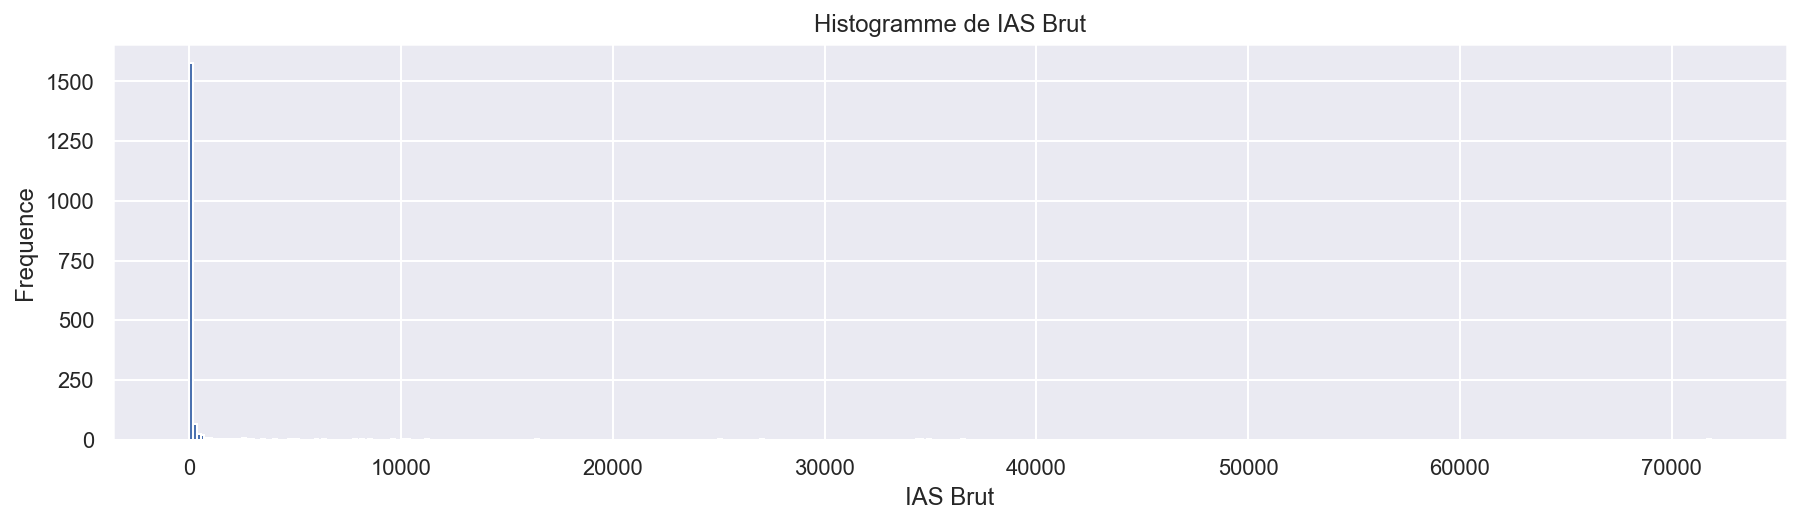

In [11]:
sns.set()
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.hist(df['IAS_brut'], bins=400)
plt.xlabel('IAS Brut')
plt.ylabel('Frequence')
plt.title("Histogramme de IAS Brut")

<font style="color:Royalblue"> 
Les pics avec grandes valeurs IAS sont de fréquences très faibles. Les valeurs de IAS sont plus souvent proches de 0. 

4. Reprenez les questions précédentes après tranformations des observations par le logarithme naturel.
Commentez.

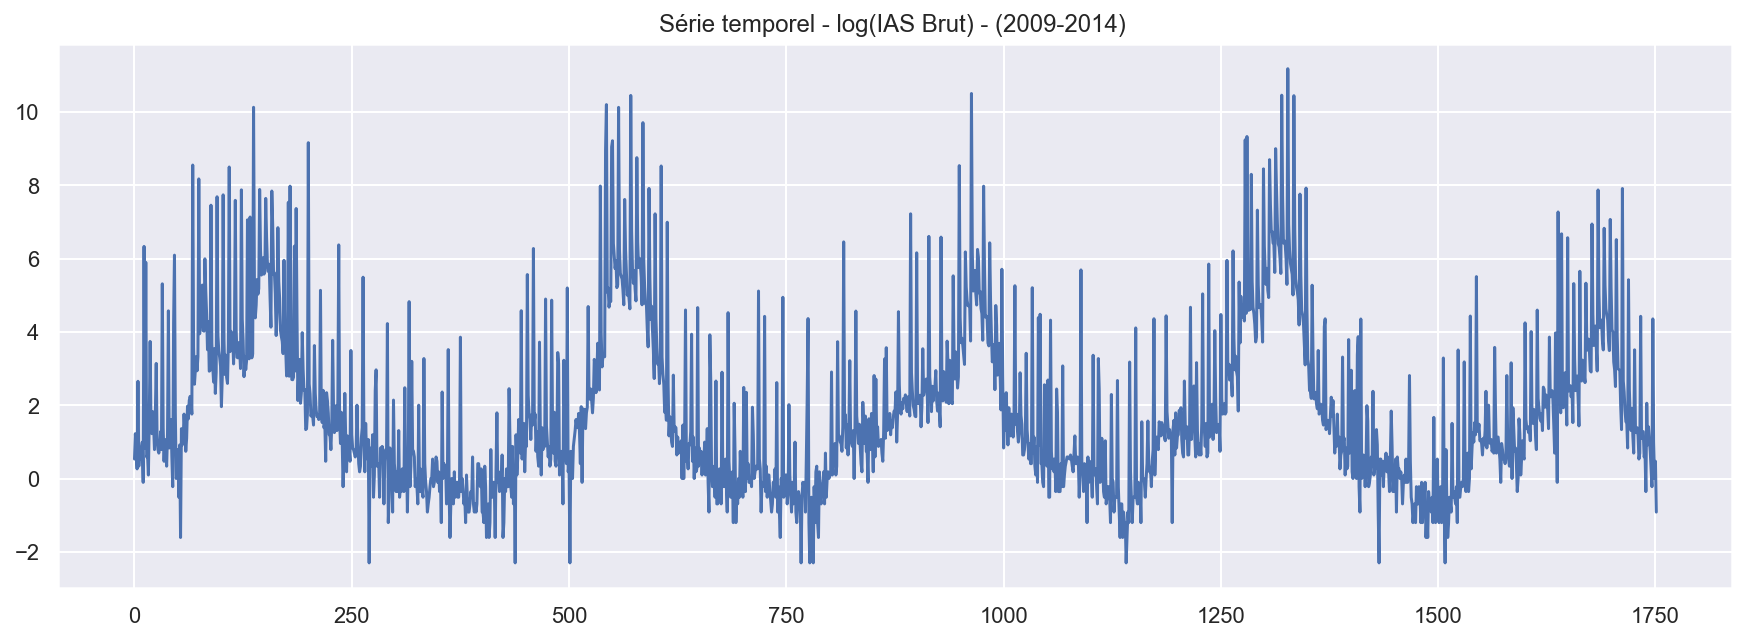

In [12]:
sns.set()
plt.figure(figsize=(15, 5))
# numpy.log is the natural logarithme
plt.plot(np.log(df['IAS_brut']))
plt.title("Série temporel - log(IAS Brut) - (2009-2014) ")
plt.show()

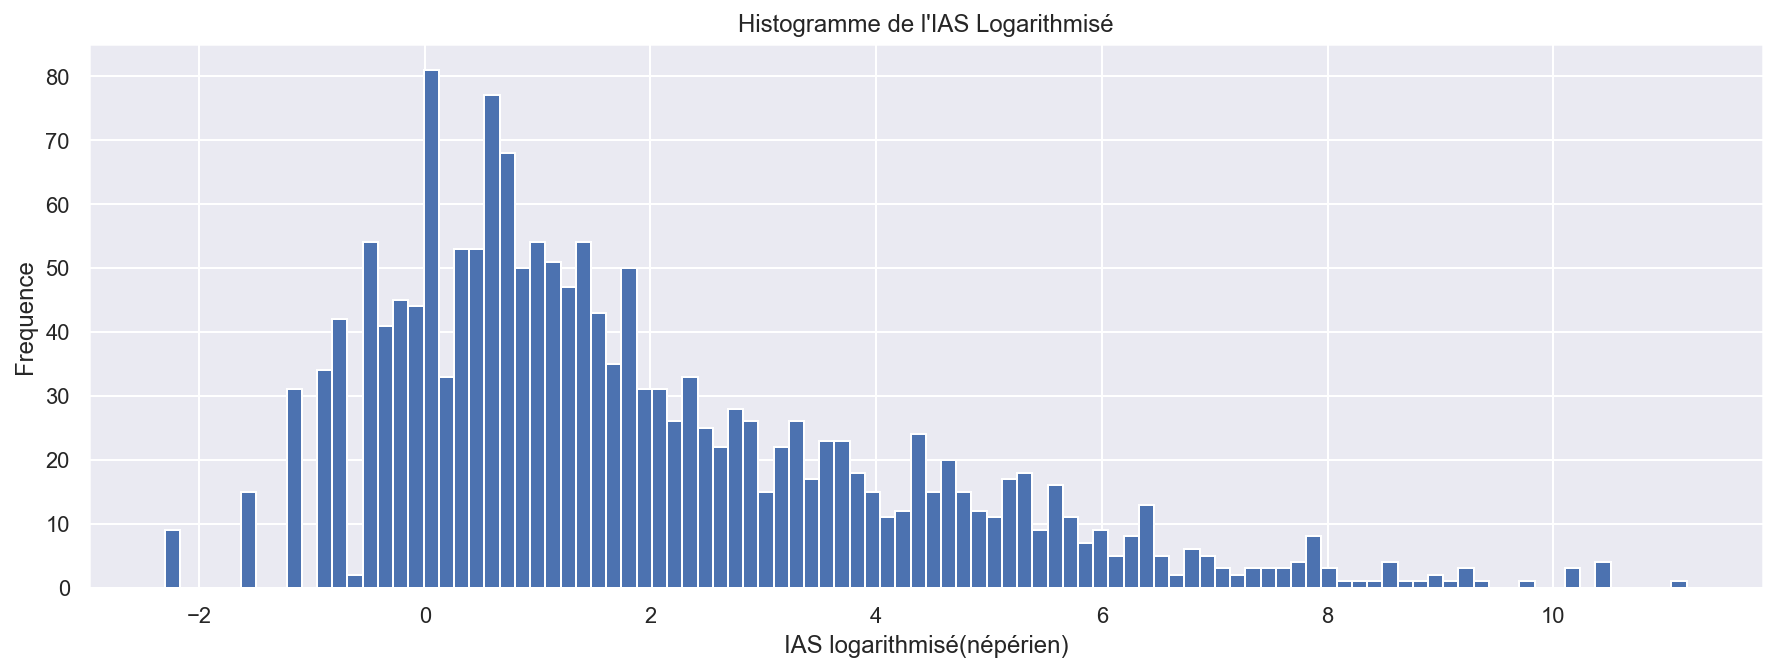

In [13]:
sns.set()
plt.figure(figsize=(15, 5))
plt.hist(np.log(df['IAS_brut']), bins=100)
plt.title("Histogramme de l'IAS Logarithmisé")
plt.xlabel('IAS logarithmisé(népérien)')
plt.ylabel('Frequence')
plt.show()
# log(IAS Brut)<0 quand IAS Brut <1

<font style="color:Royalblue"> 
Un axe logarithmique comprime l'échelle de manière non linéaire,les grands valeurs de IAS sont comprimés, rapprochés de 1, en revanche les valeurs inférieurs à 1 sont dilatés et  renvoyés vers l'infini négatif.
    
Cela signifie que des bacs de largeur variable doivent être utilisés pour les histogrammes. Ici on utilise toujours des bacs de largeur fix, ce qui permets de raprocher la 'longue queue à droite' vers 1 afin de mieux visualiser.


5. 
En utilisant signal.perodogram() (du package signal importé depuis scipy), tracez le périodo- gramme des données. Expliquez les pics les plus significatifs que vous observez. Attention au fait que dans la communauté signal les spectres sont normalisées pour des fréquences absolues dans [−1/2, 1/2] plutôt que [−π, −π].


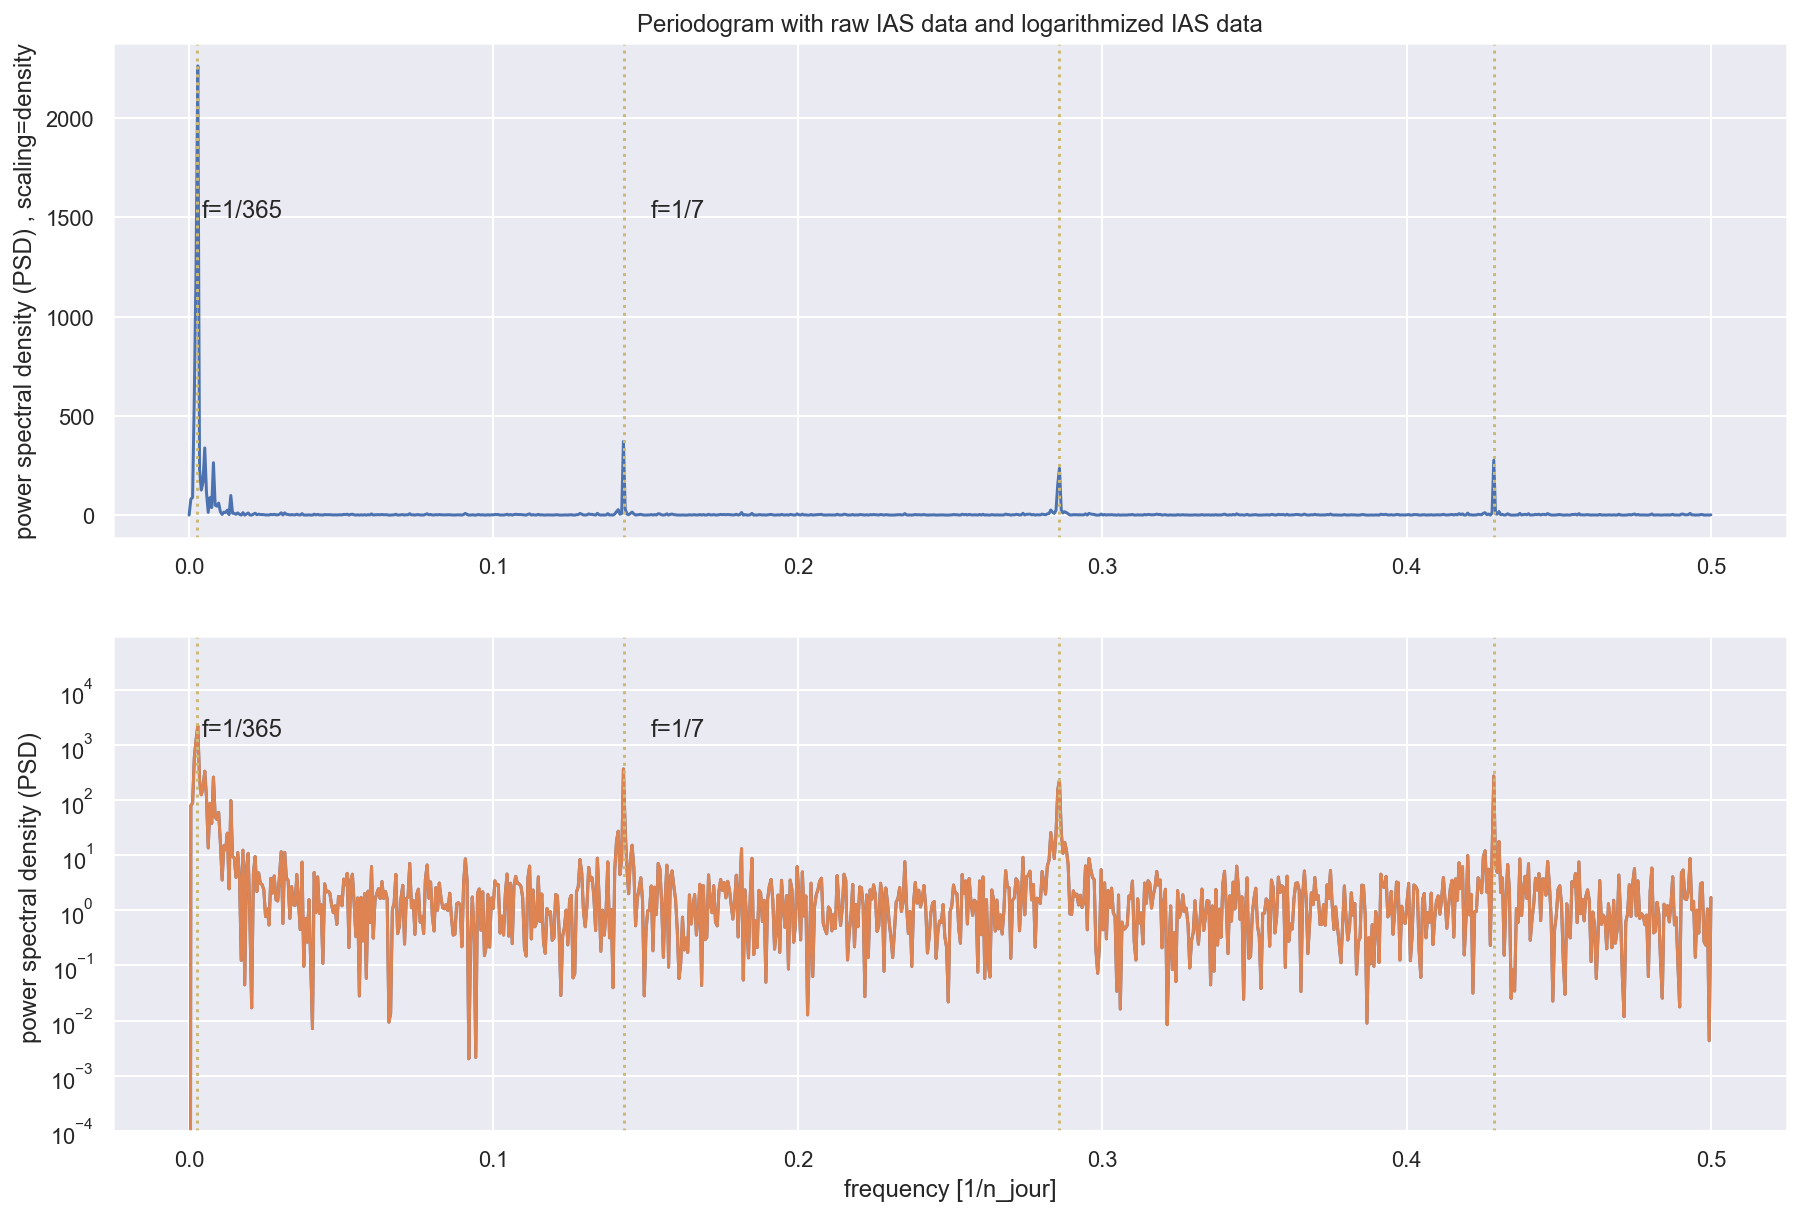

In [15]:
sns.set()
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
# f : ndarray : Array of sample frequencies.
# Pxx : ndarray :Power spectral density or power spectrum of x.
f, Pxx_den = signal.periodogram(np.log(df['IAS_brut']), scaling='density')
plt.plot(f, Pxx_den)
# plt.xlabel('frequency')
plt.axvline(x=1/7, c='y', linestyle=':')
plt.axvline(x=1/3.5, c='y', linestyle=':')
plt.axvline(x=3/7, c='y', linestyle=':')
plt.axvline(x=1/365, c='y', linestyle=':')
plt.text(1/250, 1500, 'f=1/365')
plt.text(1/6.6, 1500, 'f=1/7')
plt.ylabel('power spectral density (PSD) , scaling=density')
plt.title('Periodogram with raw IAS data and logarithmized IAS data')

plt.subplot(2, 1, 2)
f, Pxx_den = signal.periodogram(np.log(df['IAS_brut']), scaling='density')
plt.plot(f, Pxx_den)
# This is just a thin wrapper around plot which additionally changes the y-axis to log scaling.
plt.semilogy(f, Pxx_den)
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.semilogy.html
plt.ylim(10e-5,)
plt.axvline(x=1/7, c='y', linestyle=':')
plt.axvline(x=1/3.5, c='y', linestyle=':')
plt.axvline(x=3/7, c='y', linestyle=':')
plt.axvline(x=1/365, c='y', linestyle=':')
plt.text(1/250, 1500, 'f=1/365')
plt.text(1/6.6, 1500, 'f=1/7')
plt.xlabel('frequency [1/n_jour]')
plt.ylabel('power spectral density (PSD) ')
plt.show()

<font style="color:Royalblue"> 
Le périodogramme est une estimation de la densité spectrale d'un signal. Les pics sur le périodogramme montres les fréquences les plus importantes/dense. Cela corresponds avec les périodicités/saisonnalités les plus significatives.  

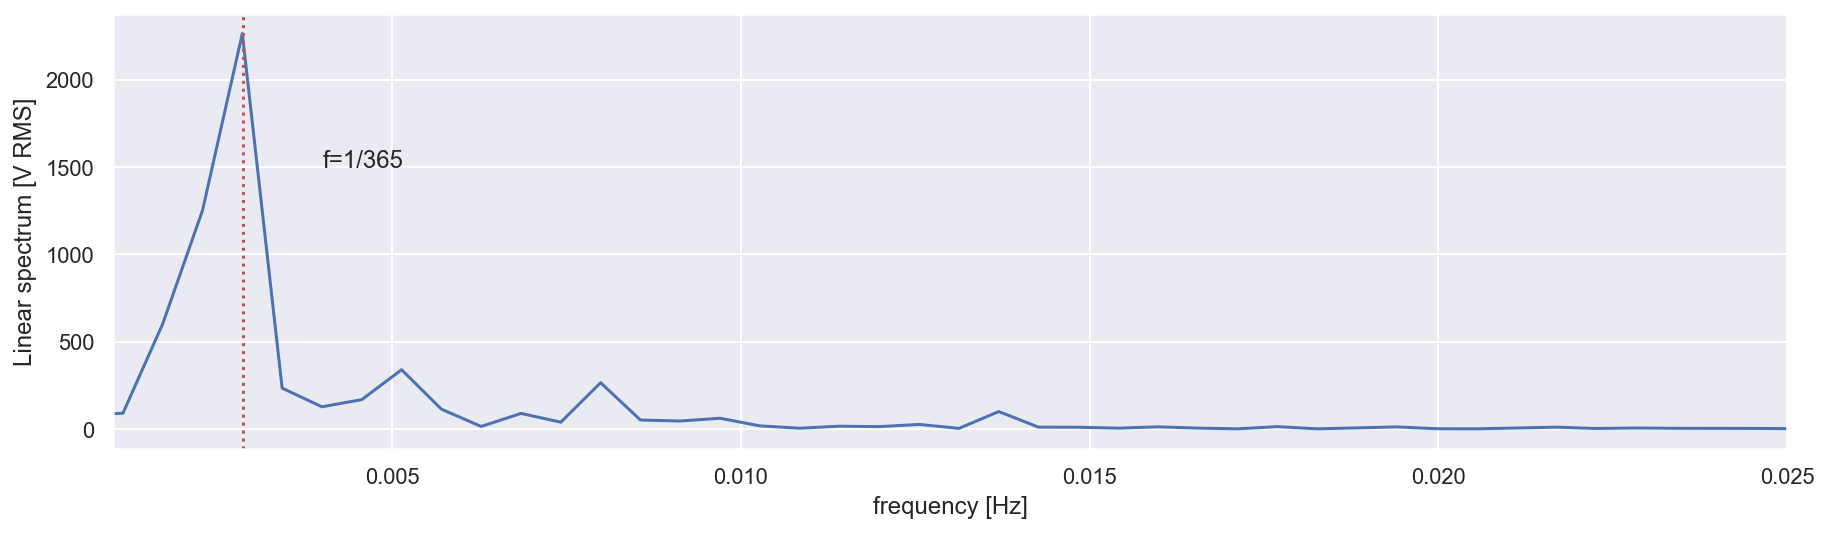

In [16]:
# show the first peak
sns.set()
plt.figure(figsize=(15, 4))
f, Pxx_den = signal.periodogram(np.log(df['IAS_brut']), scaling='density')
plt.plot(f, Pxx_den)
plt.axvline(x=1/350, c='r', linestyle=':')
plt.xlim([1/1000, 1/40])
plt.text(1/250, 1500, 'f=1/365')

plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

<font style="color:Royalblue"> 
Le permier pic corresponds à la fréquence de 1/365.

6. Pour supprimer une tendance périodique de période T dans un signal (xt)t∈Z il suffit d’appliquer
le filtre ∆T défini par
[∆T x]t = xt − xt−T
Utilisez cette méthode pour supprimer la tendance périodique de période 1 an. Quel pic du périodogramme cette méthode a fait disparaître ?

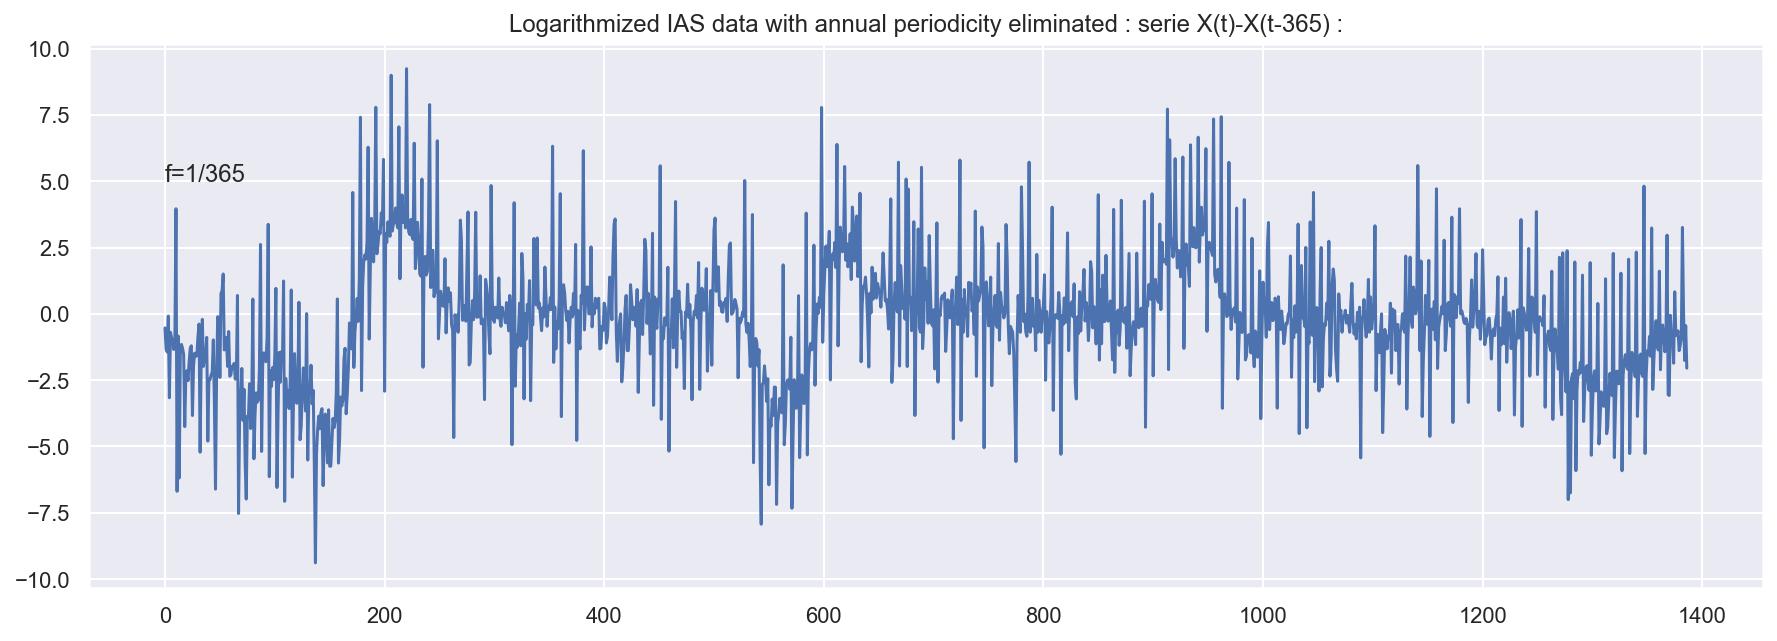

In [17]:
# On supprime l'autocorrélation annuelle
time_diff = []
for i in range(365, len(df)):
    time_diff.append(np.log(df.loc[i]['IAS_brut']) -
                     np.log(df.loc[i-365]['IAS_brut']))

sns.set()
plt.figure(figsize=(15, 5))
plt.plot(time_diff)
plt.text(1/250, 5, 'f=1/365')
plt.title(
    "Logarithmized IAS data with annual periodicity eliminated : serie X(t)-X(t-365) :")
plt.show()

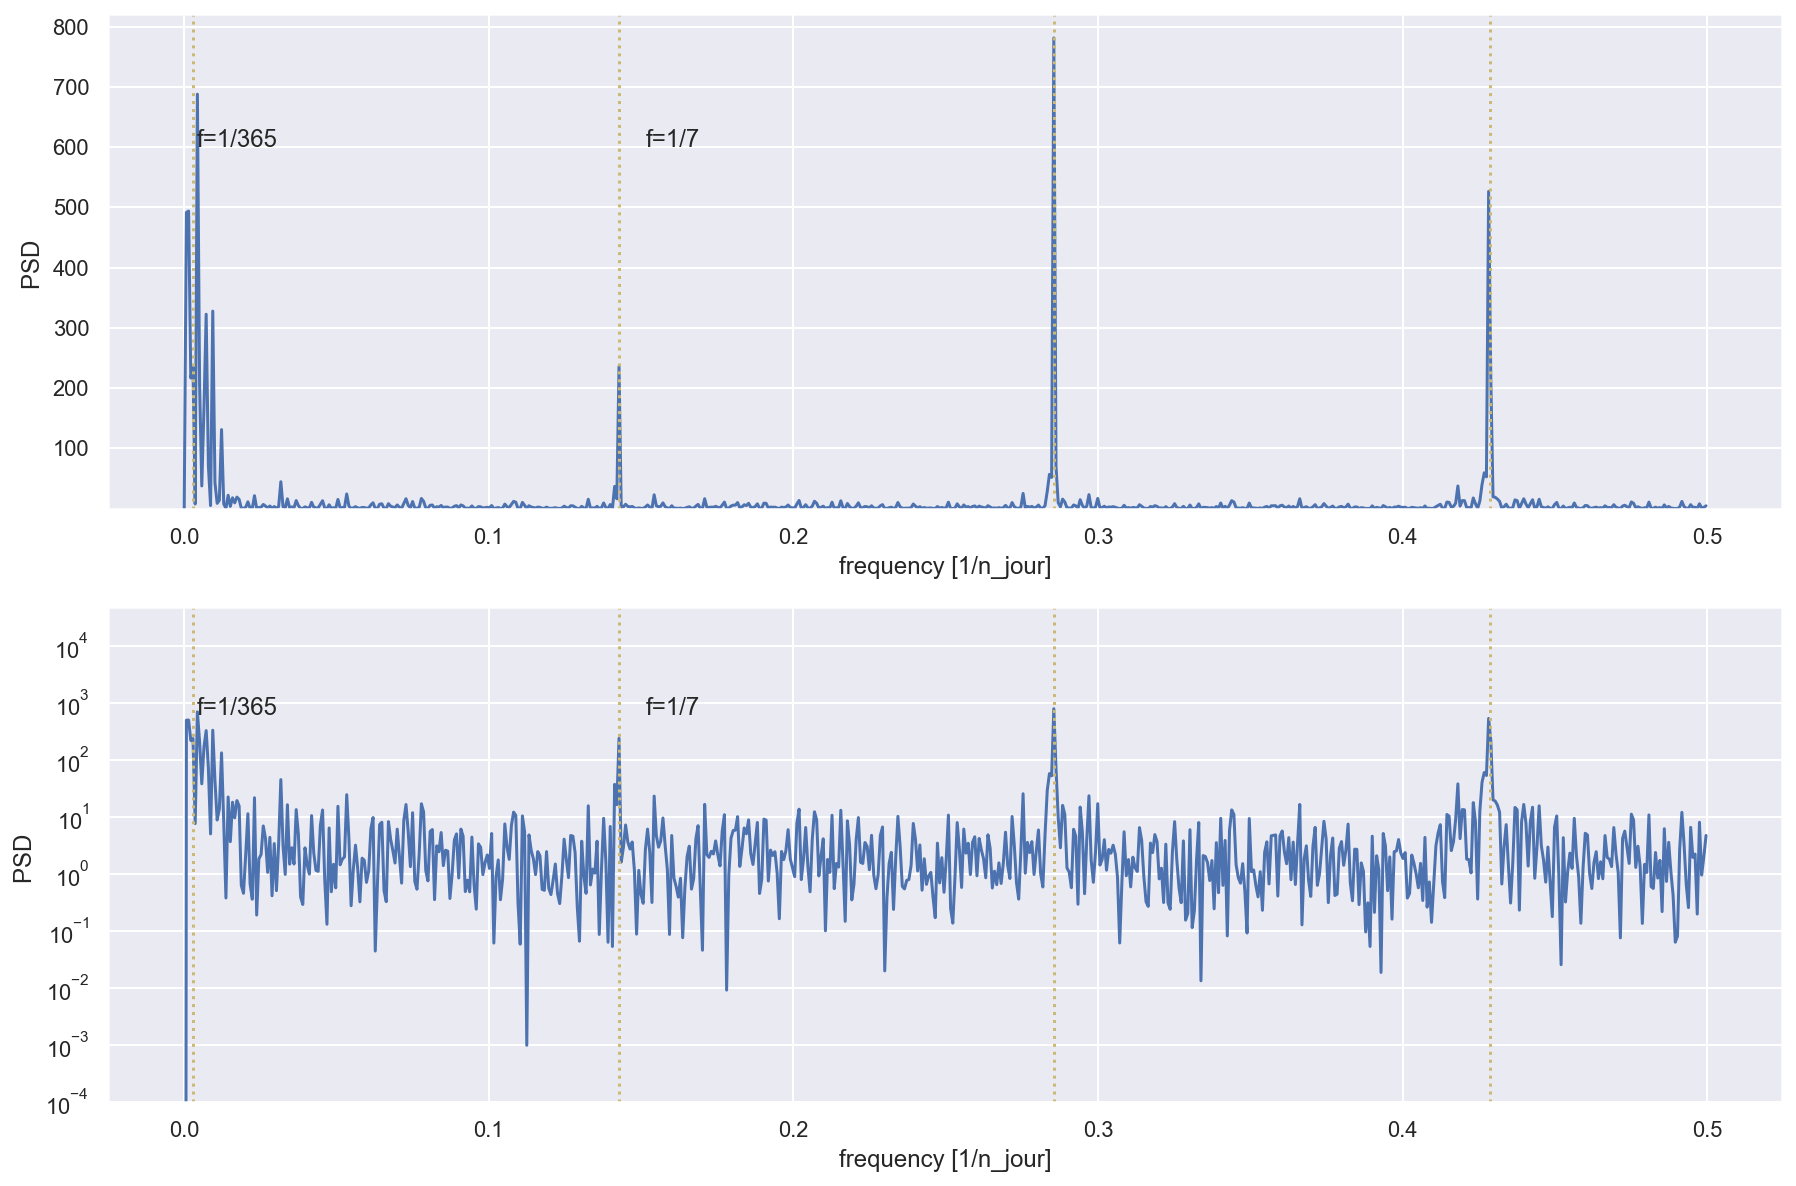

In [16]:
# periodogram with previous data
sns.set()
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
f, Pxx_den = signal.periodogram(time_diff)
plt.plot(f, Pxx_den)
plt.axvline(x=1/7, c='y', linestyle=':')
plt.axvline(x=1/3.5, c='y', linestyle=':')
plt.axvline(x=3/7, c='y', linestyle=':')
plt.axvline(x=1/365, c='y', linestyle=':')
plt.ylim(10e-5,)
plt.text(1/250, 600, 'f=1/365')
plt.text(1/6.6, 600, 'f=1/7')
plt.xlabel('frequency [1/n_jour]')
plt.ylabel('PSD ')

plt.subplot(2, 1, 2)
plt.semilogy(f, Pxx_den)
plt.axvline(x=1/7, c='y', linestyle=':')
plt.axvline(x=1/3.5, c='y', linestyle=':')
plt.axvline(x=3/7, c='y', linestyle=':')
plt.axvline(x=1/365, c='y', linestyle=':')
plt.ylim(10e-5,)
plt.text(1/250, 600, 'f=1/365')
plt.text(1/6.6, 600, 'f=1/7')
plt.xlabel('frequency [1/n_jour]')
plt.ylabel('PSD ')
plt.show()

<font style="color:Royalblue"> 
Cette méthode a fait disparaitre le pic du périodogramme sur 1/365.
Le plus grand pic maintenant corresponds aux Fréquence 1/3.5, 3/7,1/7.


7. On vous propose un exercise de prédiction uniquement à partir de la tendance périodique. On va
prédire les valeurs de IAS_brut pour les dates du 1er avril 2013 au 17 avril 2014 en se basant
sur les observations précédentes (du 1er juillet 2009 au 31 mars 2013) pour estimer la tendance
périodique des données. Pour cela, pour un nombre d’harmoniques fixé (disons n_harm), construisez
les variables explicatives pour la période d’apprentissage : pour chaque k = 1, 2, ... n_harm, ajoutez
deux variables explicatives, xi,2k−1 = cos(ti · k · 2π ) et xi,2k = sin(ti · k · 2π ), où ti est le moment TT
de temps (on peut utiliser les nombres entiers au lieu de dates) et T = 365. Estimez la tendance périodique en régressant les données d’apprentissage sur ces variables explicatives.

Avec ce modèle linéaire, prédisez les valeurs du variable IAS_brut pour la période du 1er avril 2013 au 17 avril 2014.
Tracez les valeur de la série temporelle et votre prédiction pour l’ensemble de données (vous pouvez utilisez les couleurs différentes pour pour les partie apprentissage et prédiction). 
Puis, donnez le risque quadratique de la prédiction et tracez les résidus pour la période prédite.
Essayez les valeur de n_harm pour voir comment varie le risque quadratique de la prédiction.

In [18]:
# We will try with raw IAS data and logarithmized IAS data
X = df.copy()
X = X.drop(['IAS_lisse', 'Incidence_Sentinelles'], axis=1)
X['IAS_log'] = np.log(X['IAS_brut'])
X['index'] = X.index
X.head()

PERIODE  IAS_brut   IAS_log  index
0 2009-07-01       1.7  0.530628      0
1 2009-07-02       3.4  1.223775      1
2 2009-07-03       2.1  0.741937      2
3 2009-07-04       1.3  0.262364      3
4 2009-07-05      14.2  2.653242      4

In [19]:
# try a number of harmonics
n_harm = 5

# make 2*n_harm features
for k in range(1, 2*n_harm, 2):
    X['cos' + str(k)] = np.cos(X['index'] * (k * 2 * math.pi / 365))
    k += 1
    X['sin' + str(k)] = np.sin(X['index'] * (k * 2 * math.pi / 365))

In [20]:
# features: 2n harmonics ,  label1: IAS_brut , label2:IAS_log
X.head()

PERIODE  IAS_brut   IAS_log  index      cos1      sin2      cos3  \
0 2009-07-01       1.7  0.530628      0  1.000000  0.000000  1.000000   
1 2009-07-02       3.4  1.223775      1  0.999852  0.034422  0.998667   
2 2009-07-03       2.1  0.741937      2  0.999407  0.068802  0.994671   
3 2009-07-04       1.3  0.262364      3  0.998667  0.103102  0.988023   
4 2009-07-05      14.2  2.653242      4  0.997630  0.137279  0.978740   

       sin4      cos5      sin6      cos7      sin8      cos9     sin10  
0  0.000000  1.000000  0.000000  1.000000  0.000000  1.000000  0.000000  
1  0.068802  0.996298  0.103102  0.992749  0.137279  0.988023  0.171293  
2  0.137279  0.985220  0.205104  0.971100  0.271958  0.952378  0.337523  
3  0.205104  0.966848  0.304921  0.935368  0.401488  0.893919  0.493776  
4  0.271958  0.941317  0.401488  0.886071  0.523416  0.814046  0.635432

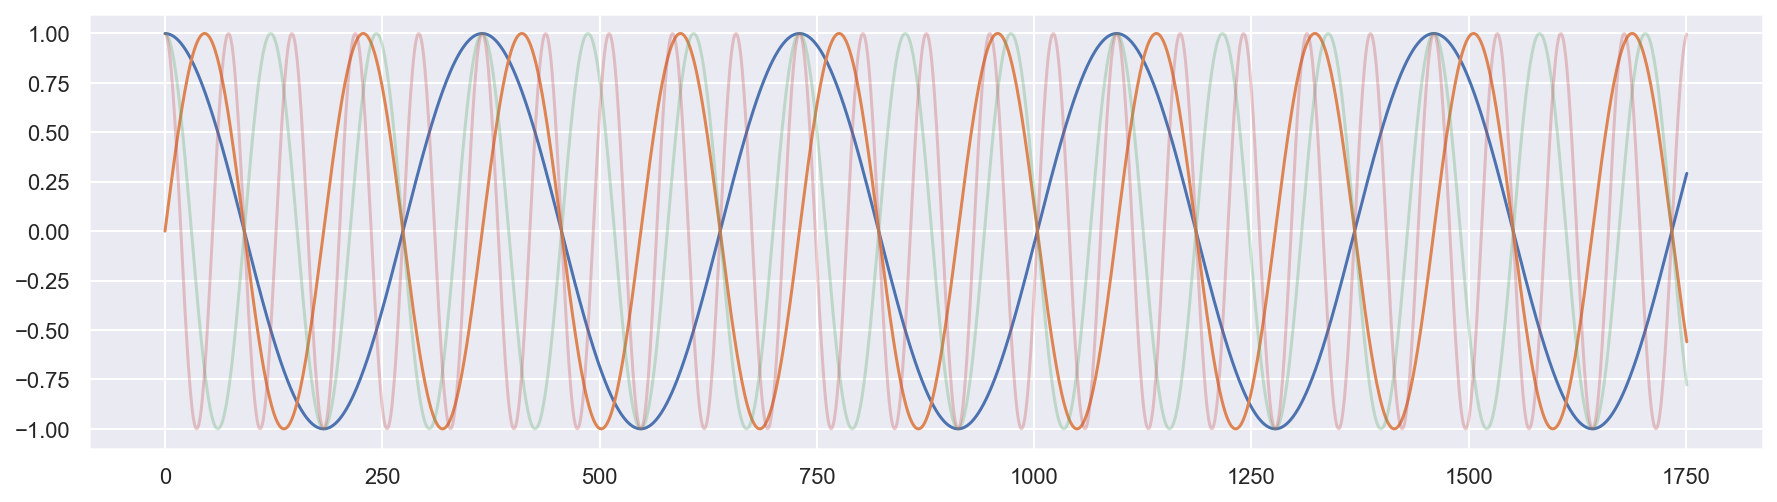

In [23]:
#  just show some harmonics
sns.set()
plt.figure(figsize=(15, 4))
plt.plot(X['cos1'])
plt.plot(X['sin2'])
plt.plot(X['cos3'], alpha=0.3)
plt.plot(X['cos5'], alpha=0.3)

In [24]:
#chose training data (time periode) and test data
X_train = X[X['PERIODE'] <= "2013-03-31"]
X_test = X[X['PERIODE'] > "2013-03-31"]

In [25]:
y_train = X_train['IAS_brut']
X_train = X_train.drop(['IAS_brut', 'IAS_log','PERIODE'], axis=1)

y_test = X_test['IAS_brut']
X_test = X_test.drop(['PERIODE', 'IAS_log','IAS_brut'], axis = 1)
X_train.head()

index      cos1      sin2      cos3      sin4      cos5      sin6  \
0      0  1.000000  0.000000  1.000000  0.000000  1.000000  0.000000   
1      1  0.999852  0.034422  0.998667  0.068802  0.996298  0.103102   
2      2  0.999407  0.068802  0.994671  0.137279  0.985220  0.205104   
3      3  0.998667  0.103102  0.988023  0.205104  0.966848  0.304921   
4      4  0.997630  0.137279  0.978740  0.271958  0.941317  0.401488   

       cos7      sin8      cos9     sin10  
0  1.000000  0.000000  1.000000  0.000000  
1  0.992749  0.137279  0.988023  0.171293  
2  0.971100  0.271958  0.952378  0.337523  
3  0.935368  0.401488  0.893919  0.493776  
4  0.886071  0.523416  0.814046  0.635432

Estimez la tendance périodique en régressant les données d’apprentissage sur ces variables explicatives.

In [26]:
X_train_pred = X_train.copy()

In [27]:
X_train_pred.head()

index      cos1      sin2      cos3      sin4      cos5      sin6  \
0      0  1.000000  0.000000  1.000000  0.000000  1.000000  0.000000   
1      1  0.999852  0.034422  0.998667  0.068802  0.996298  0.103102   
2      2  0.999407  0.068802  0.994671  0.137279  0.985220  0.205104   
3      3  0.998667  0.103102  0.988023  0.205104  0.966848  0.304921   
4      4  0.997630  0.137279  0.978740  0.271958  0.941317  0.401488   

       cos7      sin8      cos9     sin10  
0  1.000000  0.000000  1.000000  0.000000  
1  0.992749  0.137279  0.988023  0.171293  
2  0.971100  0.271958  0.952378  0.337523  
3  0.935368  0.401488  0.893919  0.493776  
4  0.886071  0.523416  0.814046  0.635432

In [29]:
# use linear regression
# the features are harmonics , label is IAS data
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
pred = reg.predict(X_test)
X_train_fit = reg.predict(X_train)

print('The weights of intercept and the features(harmonics):')
print(reg.coef_)

The weights of intercept and the features(harmonics):
[ 2.97597104e-01 -5.48213297e+02  3.80046791e+02  9.45722945e+01
  5.50231412e+01  1.03784280e+02 -1.61630047e+02 -2.95835718e+02
  1.16577290e+02 -1.17099138e+02  7.46308105e+01]


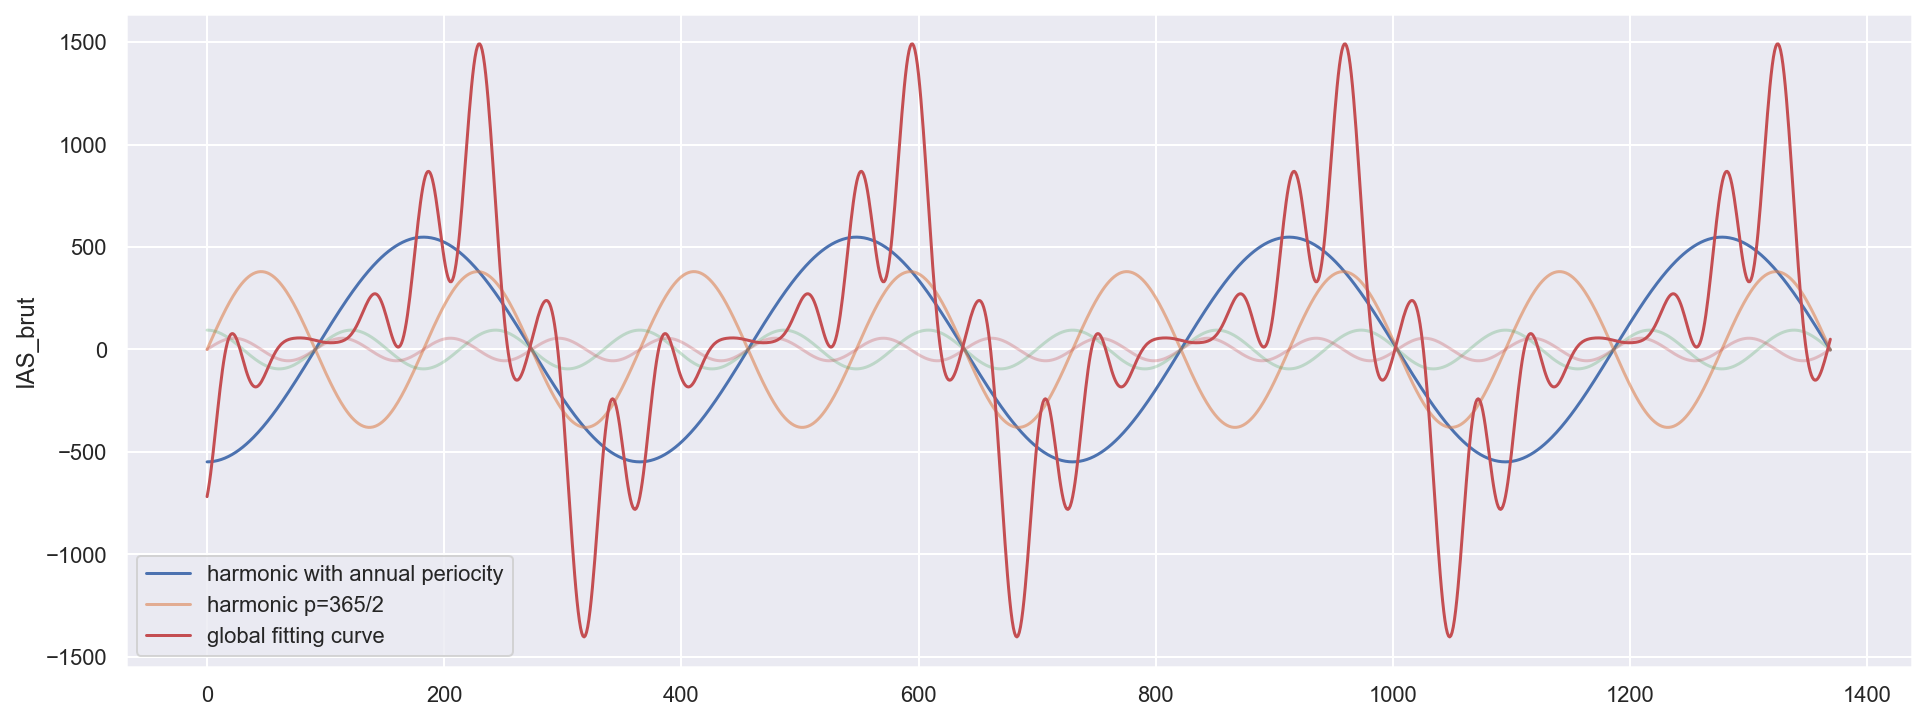

In [30]:
# Calculate the fitting curve on training data
X_train_pred = X_train.copy()
X_train_pred = X_train_pred.drop(['index'], axis=1)
X_train_pred.insert(loc=0, column='intercept', value=reg.intercept_)
for i in range(len(reg.coef_)):
    # print(X_train_pred.iloc[0,i],reg.coef_[i])
    X_train_pred.iloc[:, i] = X_train_pred.iloc[:, i]*reg.coef_[i]
X_train_pred.insert(loc=len(reg.coef_), column='pred', value=0)

for i in range(len(reg.coef_)):
    # print(i,X_train_pred.iloc[0,i])
    X_train_pred['pred'] = X_train_pred['pred']+X_train_pred.iloc[:, i]

# show the first Harmonics(features) with weights
sns.set()
plt.figure(figsize=(16, 6))
plt.plot(X_train_pred['cos1'], label='harmonic with annual periocity')
plt.plot(X_train_pred['sin2'], label='harmonic p=365/2', alpha=0.6)
plt.plot(X_train_pred['cos3'], alpha=0.3)
plt.plot(X_train_pred['sin4'], alpha=0.3)
# plt.plot(X_train_pred['cos5'],alpha=0.3)
# plt.plot(X_train_pred['sin6'],alpha=0.3)
plt.ylabel('IAS_brut')
plt.plot(X_train_pred['pred'], label='global fitting curve', color='r')
plt.legend()

<font style="color:Royalblue"> 

Le plus grand poids (-5.48213297e+02) est sur l'harmonique blue cos(2*pi/365) : périodicité annuelle. C'est l'harmonique la plus importante, cela corrésponds tout à fait avec la question 5 et l'analyse sur la périodogram.


Avec ce modèle linéaire, prédisez les valeurs du variable IAS_brut pour la période du 1er avril 2013
au 17 avril 2014.

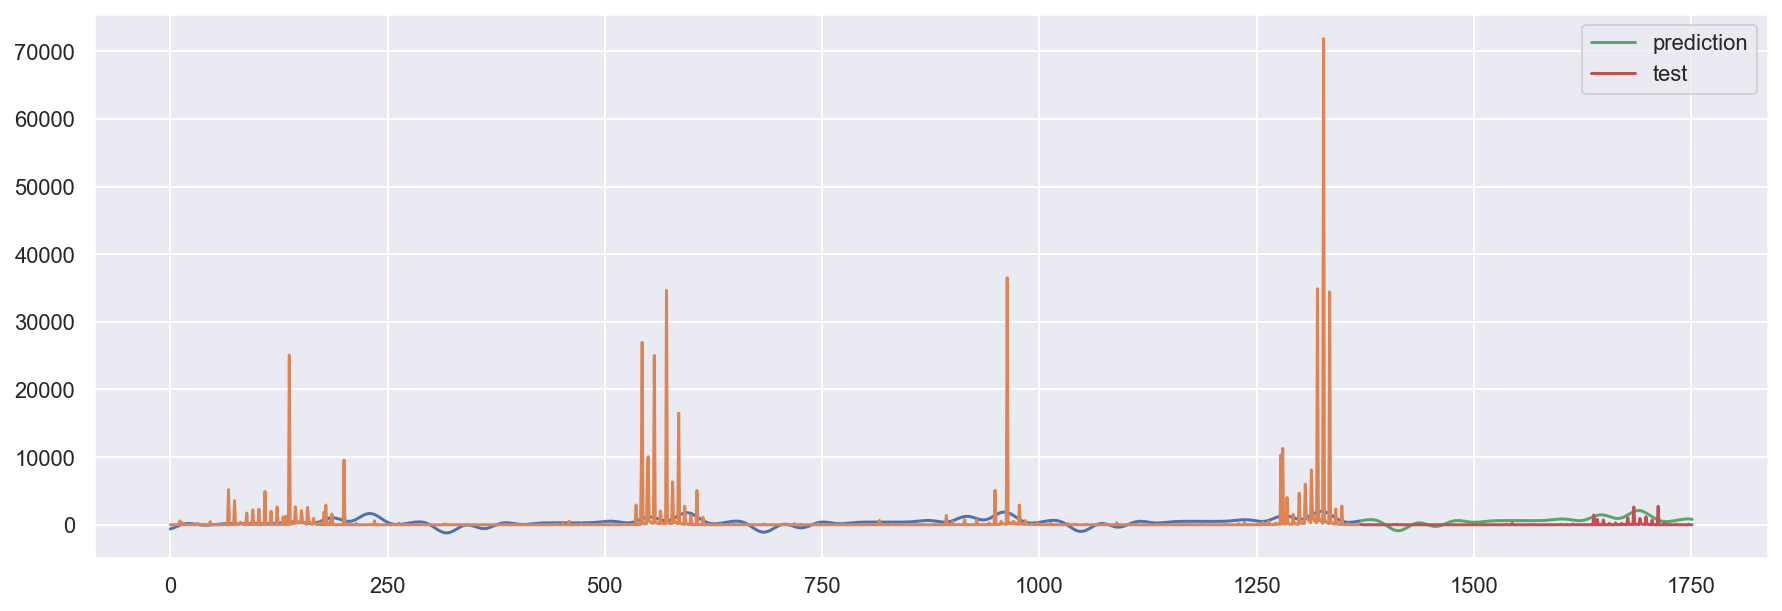

In [31]:
# show the sum of all weighted variables
# compare with the real historic data
sns.set()
plt.figure(figsize=(15, 5))
#plt.plot(X_train['index'],X_train_pred['pred'],label='fit on train data')
plt.plot(X_train['index'], X_train_fit)
plt.plot(X_train['index'], y_train)
plt.plot(X_test['index'], pred, label='prediction')
plt.plot(X_test['index'], y_test, label='test')
plt.legend()
plt.show()

Donnez le risque quadratique de la prédiction et tracez les résidus pour la période prédite.
Essayez les valeur de n_harm pour voir comment varie le risque quadratique de la prédiction.

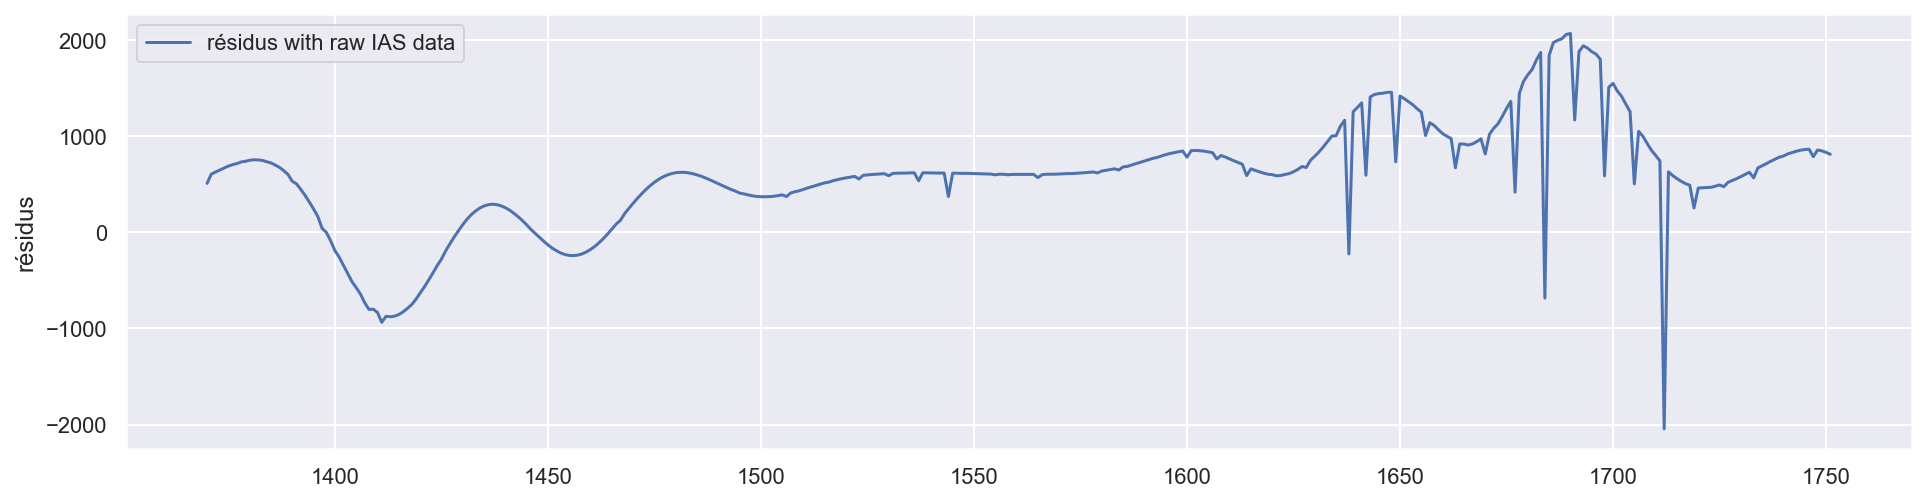

In [32]:
residus_brut = pred - y_test
quad_risk = sum((y_test - pred)**2)
quad_risk
plt.figure(figsize=(16, 4))
plt.plot(residus_brut, label='résidus with raw IAS data')
plt.ylabel('résidus')
plt.legend()

<font style="color:Royalblue"> 
Avec 10 harmoniques(features), le modèle prédicte assez bien.

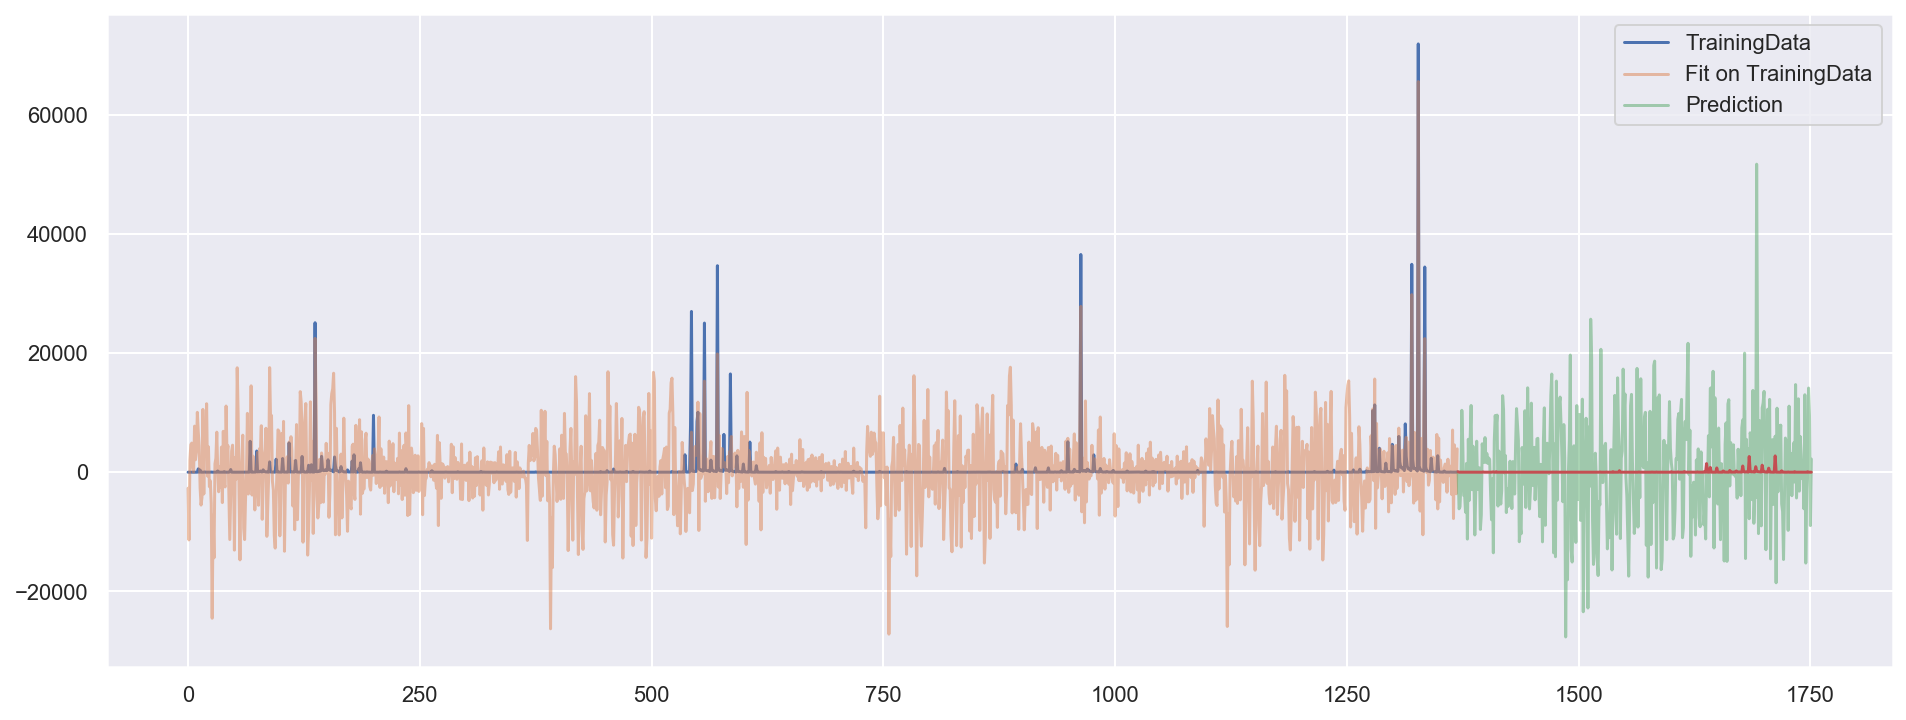

In [33]:
# with large n_harm, the model will overfit
n_harm = 500

X = df.copy()
X = X.drop(['IAS_lisse', 'Incidence_Sentinelles'], axis=1)
X['IAS_log'] = np.log(X['IAS_brut'])
X['index'] = X.index

for k in range(1, 2*n_harm, 2):
    X['cos' + str(k)] = np.cos(X['index'] * (k * 2 * math.pi / 365))
    k += 1
    X['sin' + str(k)] = np.sin(X['index'] * (k * 2 * math.pi / 365))

X_train = X[X['PERIODE'] <= "2013-03-31"]
X_test = X[X['PERIODE'] > "2013-03-31"]

y_train = X_train['IAS_brut']
X_train = X_train.drop(['IAS_brut', 'IAS_log', 'PERIODE'], axis=1)
y_test = X_test['IAS_brut']
X_test = X_test.drop(['PERIODE', 'IAS_log', 'IAS_brut'], axis=1)

# Linear Regression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)
pred = reg.predict(X_test)
X_train_fit = reg.predict(X_train)

sns.set()
plt.figure(figsize=(16, 6))
plt.plot(y_train, label="TrainingData")
plt.plot(X_train['index'], X_train_fit, alpha=0.5, label="Fit on TrainingData")
plt.plot(X_test['index'], pred, label="Prediction", alpha=0.5)
plt.plot(X_test['index'], y_test)  # label="TestData"
plt.legend()
plt.show()

<font style="color:Royalblue"> 
Avec large nombre de harmoniques(features), 500 par example, le modèle rencontre le problème de 'overfitting'/surapprendissage. Le risque empirique dimimue alors que le risque de généralisation augemente. Ce problème est particulièrement grave ici puisque il y a des valeurs extremes.

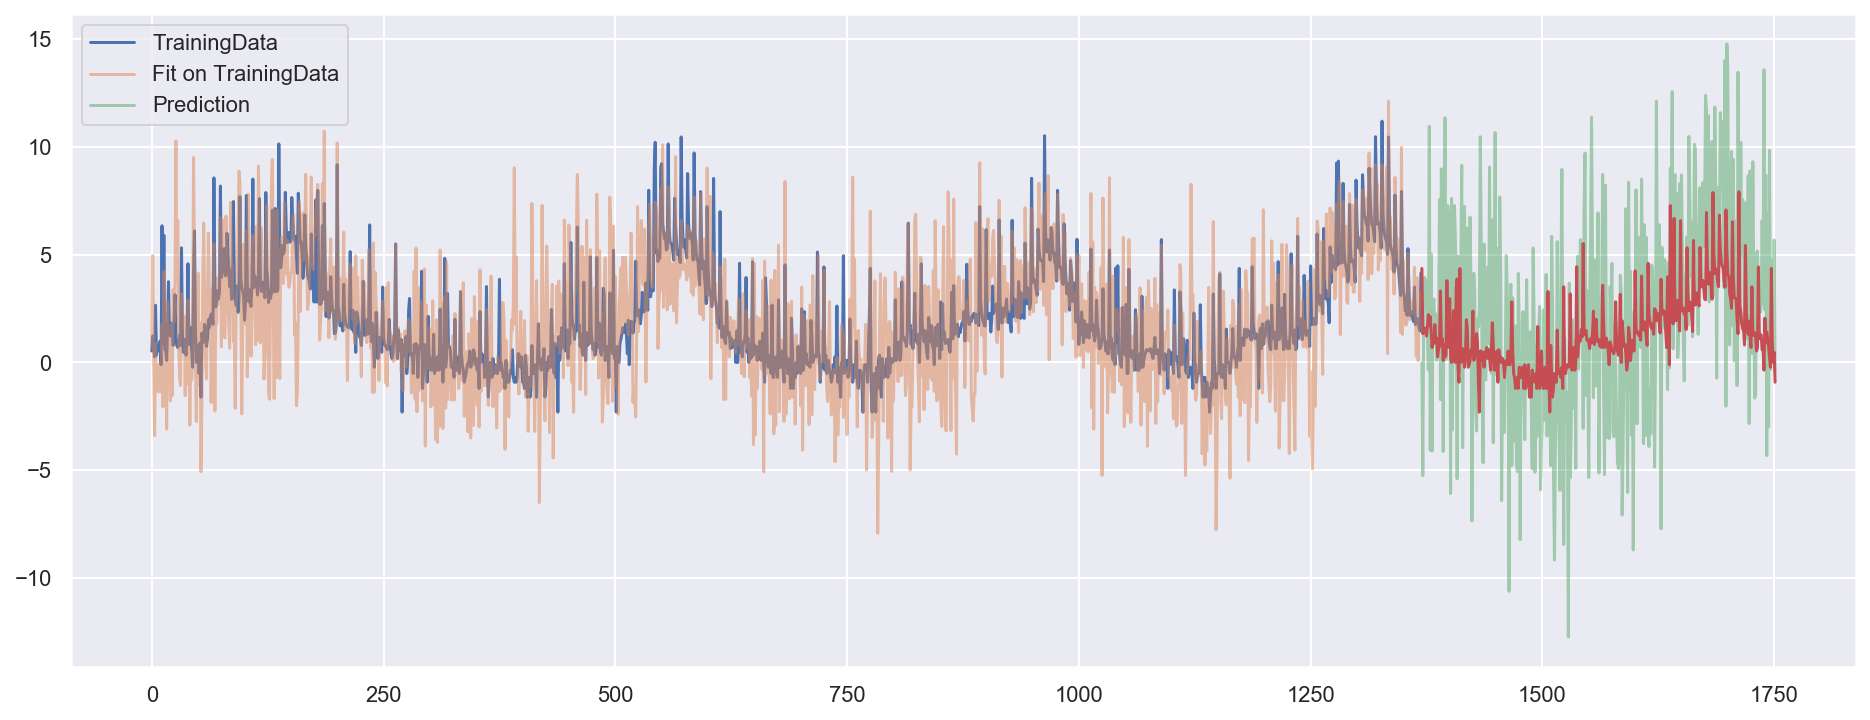

In [34]:
# Test with logarithmized data

n_harm = 500
X = df.copy()
X = X.drop(['IAS_lisse', 'Incidence_Sentinelles'], axis=1)
X['IAS_log'] = np.log(X['IAS_brut'])
X['index'] = X.index

for k in range(1, 2*n_harm, 2):
    X['cos' + str(k)] = np.cos(X['index'] * (k * 2 * math.pi / 365))
    k += 1
    X['sin' + str(k)] = np.sin(X['index'] * (k * 2 * math.pi / 365))

X_train = X[X['PERIODE'] <= "2013-03-31"]
X_test = X[X['PERIODE'] > "2013-03-31"]

y_train = X_train['IAS_log']
X_train = X_train.drop(['IAS_brut', 'IAS_log', 'PERIODE'], axis=1)

y_test = X_test['IAS_log']
X_test = X_test.drop(['PERIODE', 'IAS_log', 'IAS_brut'], axis=1)

# Linear Regression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)
# reg.coef_
# reg.intercept_
pred = reg.predict(X_test)
X_train_fit = reg.predict(X_train)

plt.figure(figsize=(16, 6))
plt.plot(X_train['index'], y_train, label="TrainingData")
plt.plot(X_train['index'], X_train_fit, alpha=0.5, label="Fit on TrainingData")
plt.plot(X_test['index'], pred, label="Prediction", alpha=0.5)
plt.plot(X_test['index'], y_test)  # label="TestData"
plt.legend()
plt.show()

<font style="color:Royalblue"> 
Un essaie avec données logarithmisés. On obtient moins de surapprendissage. 

In [35]:
# make a loop to calculate the Square Error with different n_harmonique
residus_brut = []
residus_log = []
quad_risk_brut = []
quad_risk_log = []
n_harmonique = []
for n_harm in range(1, 100, 3):
    n_harmonique.append(n_harm)
    X = df.copy()
    X = X.drop(['IAS_lisse', 'Incidence_Sentinelles'], axis=1)
    X['IAS_log'] = np.log(X['IAS_brut'])
    X['index'] = X.index

    for k in range(1, 2*n_harm, 2):
        X['cos' + str(k)] = np.cos(X['index'] * (k * 2 * math.pi / 365))
        k += 1
        X['sin' + str(k)] = np.sin(X['index'] * (k * 2 * math.pi / 365))

    # use raw IAS data and logarithmized IAS data
    X_train = X[X['PERIODE'] <= "2013-03-31"]
    X_test = X[X['PERIODE'] > "2013-03-31"]
    y_train_brut = X_train['IAS_brut']
    y_train_log = X_train['IAS_log']
    X_train = X_train.drop(['IAS_brut', 'PERIODE', 'IAS_log'], axis=1)
    y_test_brut = X_test['IAS_brut']
    y_test_log = X_test['IAS_log']
    X_test = X_test.drop(['PERIODE', 'IAS_brut', 'IAS_log'], axis=1)

    reg_brut = LinearRegression().fit(X_train, y_train_brut)
    reg_log = LinearRegression().fit(X_train, y_train_log)
    #reg.score(X_train, y_train)

    reg.coef_

    reg.intercept_

    pred_brut = reg_brut.predict(X_test)
    pred_log = reg_log.predict(X_test)
    quad_risk_brut.append(sum((y_test_brut - pred_brut)**2))
    quad_risk_log.append(sum((y_test_log - pred_log)**2))

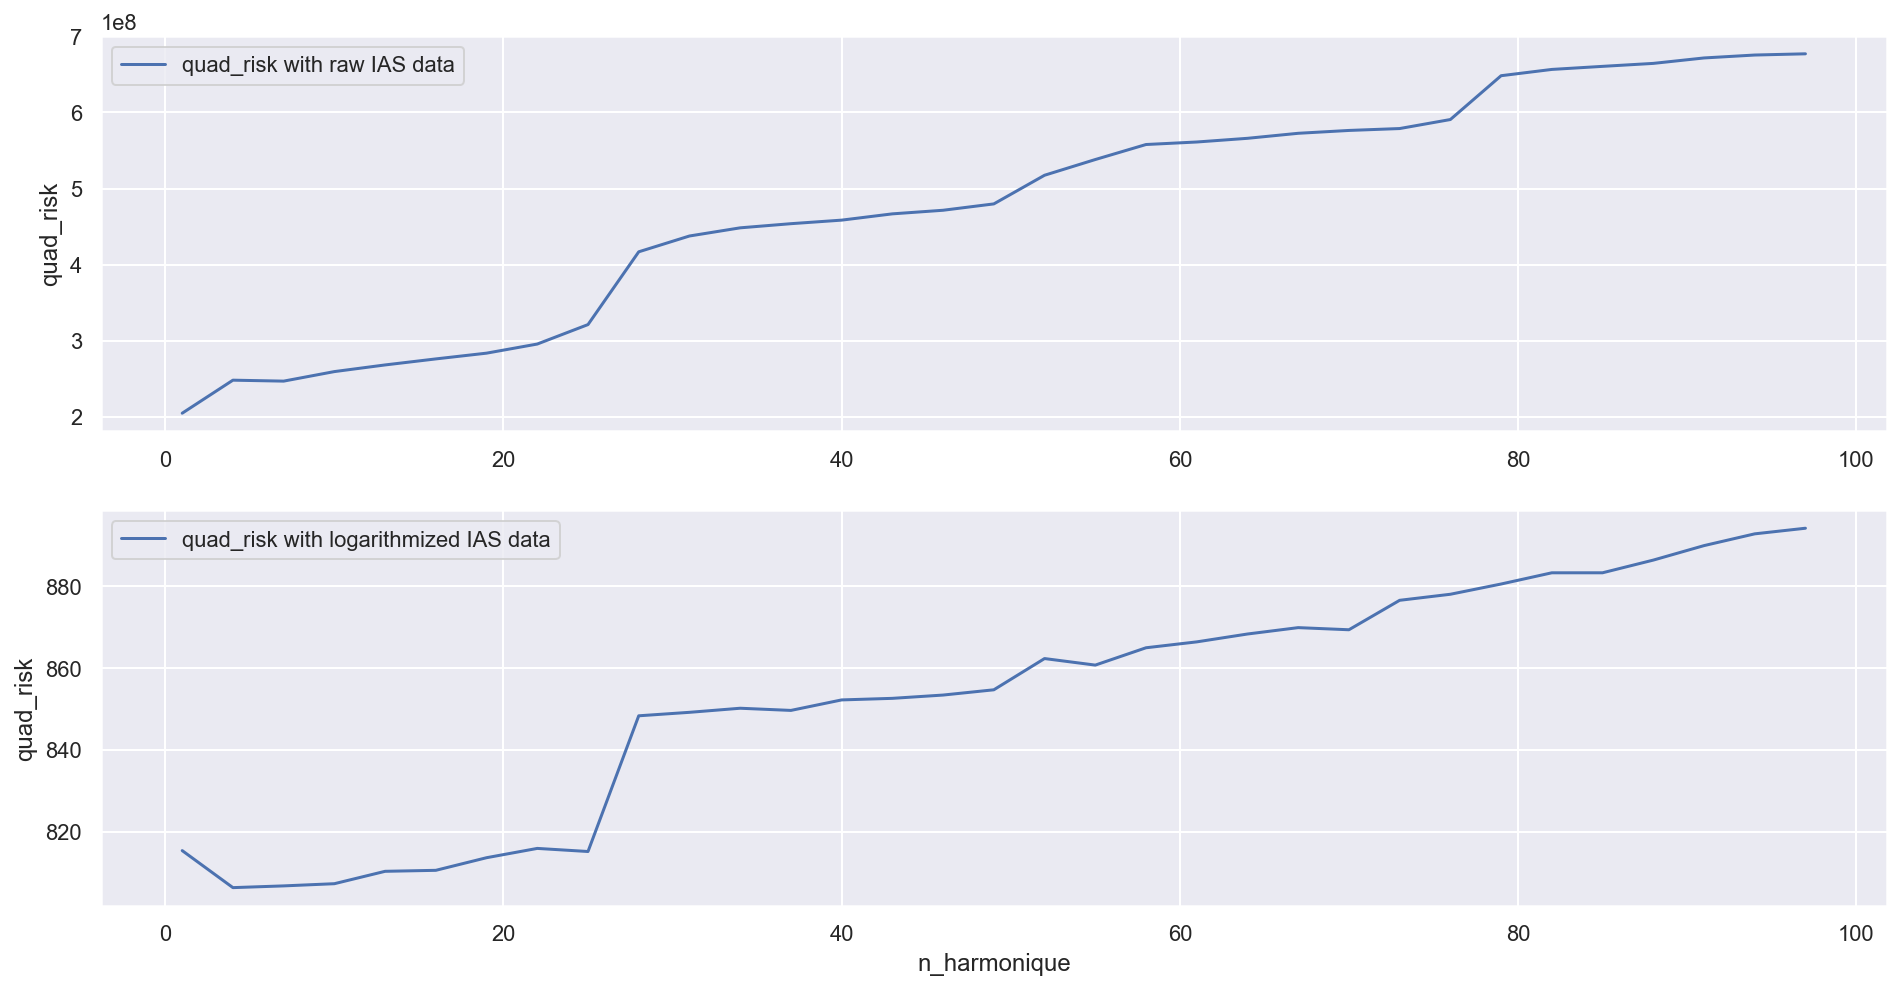

In [36]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(n_harmonique, quad_risk_brut, label='quad_risk with raw IAS data')
plt.ylabel('quad_risk')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(n_harmonique, quad_risk_log,
         label='quad_risk with logarithmized IAS data')
plt.xlabel('n_harmonique')
plt.ylabel('quad_risk')
plt.legend()
plt.show()

<font style="color:Royalblue">
Plus le nombre d'harmoniques est élevé, plus le modèle est complexe avec risque de surapprendissage. Le risque quadratique est optimal avec le nombre d'harmonique très petit. C'est aussi par ce que le 1er harmonique est déjà sur une périocité annuelle.

In [37]:
#use statmodel O function
est = sm.OLS(y_train, X_train).fit()
print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:                IAS_log   R-squared (uncentered):                   0.574
Model:                            OLS   Adj. R-squared (uncentered):              0.503
Method:                 Least Squares   F-statistic:                              8.109
Date:                Sun, 26 Jan 2020   Prob (F-statistic):                   5.57e-122
Time:                        21:57:37   Log-Likelihood:                         -2910.0
No. Observations:                1370   AIC:                                      6210.
Df Residuals:                    1175   BIC:                                      7228.
Df Model:                         195                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Données “Trafic internet” 

8) Importez les données du fichier lbl-tcp-3.tcp. Chaque ligne du tableau correspond à un paquet et la première variable et le moment de sa transmission ; consultez ftp://ita.ee.lbl.gov/html/ contrib/LBL-TCP-3.html pour plus d’information sur les données. Affichez 5 premières lignes du jeu de données.
Tout d’abord, créez la série temporelle, où chaque observation correspond au nombre de paquets transmis dans un intervalle de 10 secondes. Il y a 720 intervalles, donc vous devez obtenir 720 observations.
Tracez la série temporelle obtenue.

In [38]:
col_names = ["timestamp", "sourceHost", "destinationHost",
             "sourceTCPPort", "destinationTCPPort", "bytes"]
df2 = pd.read_csv("lbl-tcp-3.tcp", delimiter=" ", names=col_names, header=None)
df2.head()

timestamp  sourceHost  destinationHost  sourceTCPPort  \
0  7.591038e+08           1                2             23   
1  1.044500e-02           2                1           2436   
2  2.377500e-02           1                2             23   
3  2.655800e-02           2                1           2436   
4  2.900200e-02           3                4           3930   

   destinationTCPPort  bytes  
0                2436      1  
1                  23      2  
2                2436      2  
3                  23      1  
4                 119     42

"The trace ran from 14:10 to 16:10 on Thursday, January 20, 1994 (times are Pacific Standard Time), capturing 1.8 million TCP packets (about 0.0002 of these were dropped). The tracing was done on the Ethernet DMZ network over which flows all traffic into or out of the Lawrence Berkeley Laboratory, located in Berkeley, California. The raw trace was made using tcpdump on a Sun Sparcstation using the BPF kernel packet filter. Timestamps have microsecond precision."

In [39]:
df2['index'] = df2.index
df2['timedelta'] = df2['timestamp'].map(lambda x: datetime.timedelta(x))
df2.head()

timestamp  sourceHost  destinationHost  sourceTCPPort  \
0  7.591038e+08           1                2             23   
1  1.044500e-02           2                1           2436   
2  2.377500e-02           1                2             23   
3  2.655800e-02           2                1           2436   
4  2.900200e-02           3                4           3930   

   destinationTCPPort  bytes  index                       timedelta  
0                2436      1      0  759103800 days, 0:11:47.176208  
1                  23      2      1                  0:15:02.448000  
2                2436      2      2                  0:34:14.160000  
3                  23      1      3                  0:38:14.611200  
4                 119     42      4                  0:41:45.772800

In [40]:
df2.at[0, 'timedelta'] = 0
df2['timedelta'] = df2['timedelta']/86400
#df2.head()

In [42]:
# count the transferted parquets for every 10s
bytes_cum_array = []
bytes_cum = 0
#i = 0

for index in range(1, len(df2)-1):
    if index > 0:
        time_cum = df2.loc[index, 'timedelta'].total_seconds(
        ) - len(bytes_cum_array) * 10
        bytes_cum = bytes_cum + df2.loc[index, 'bytes']
        if time_cum >= 10:
            bytes_cum_array.append(bytes_cum)
            bytes_cum = 0

In [43]:
df_paquets = pd.DataFrame(bytes_cum_array, columns=['bytes'])
df_paquets['time'] = df_paquets.index
df_paquets.head()

bytes  time
0  100180     0
1  128214     1
2  657071     2
3  165290     3
4  257638     4

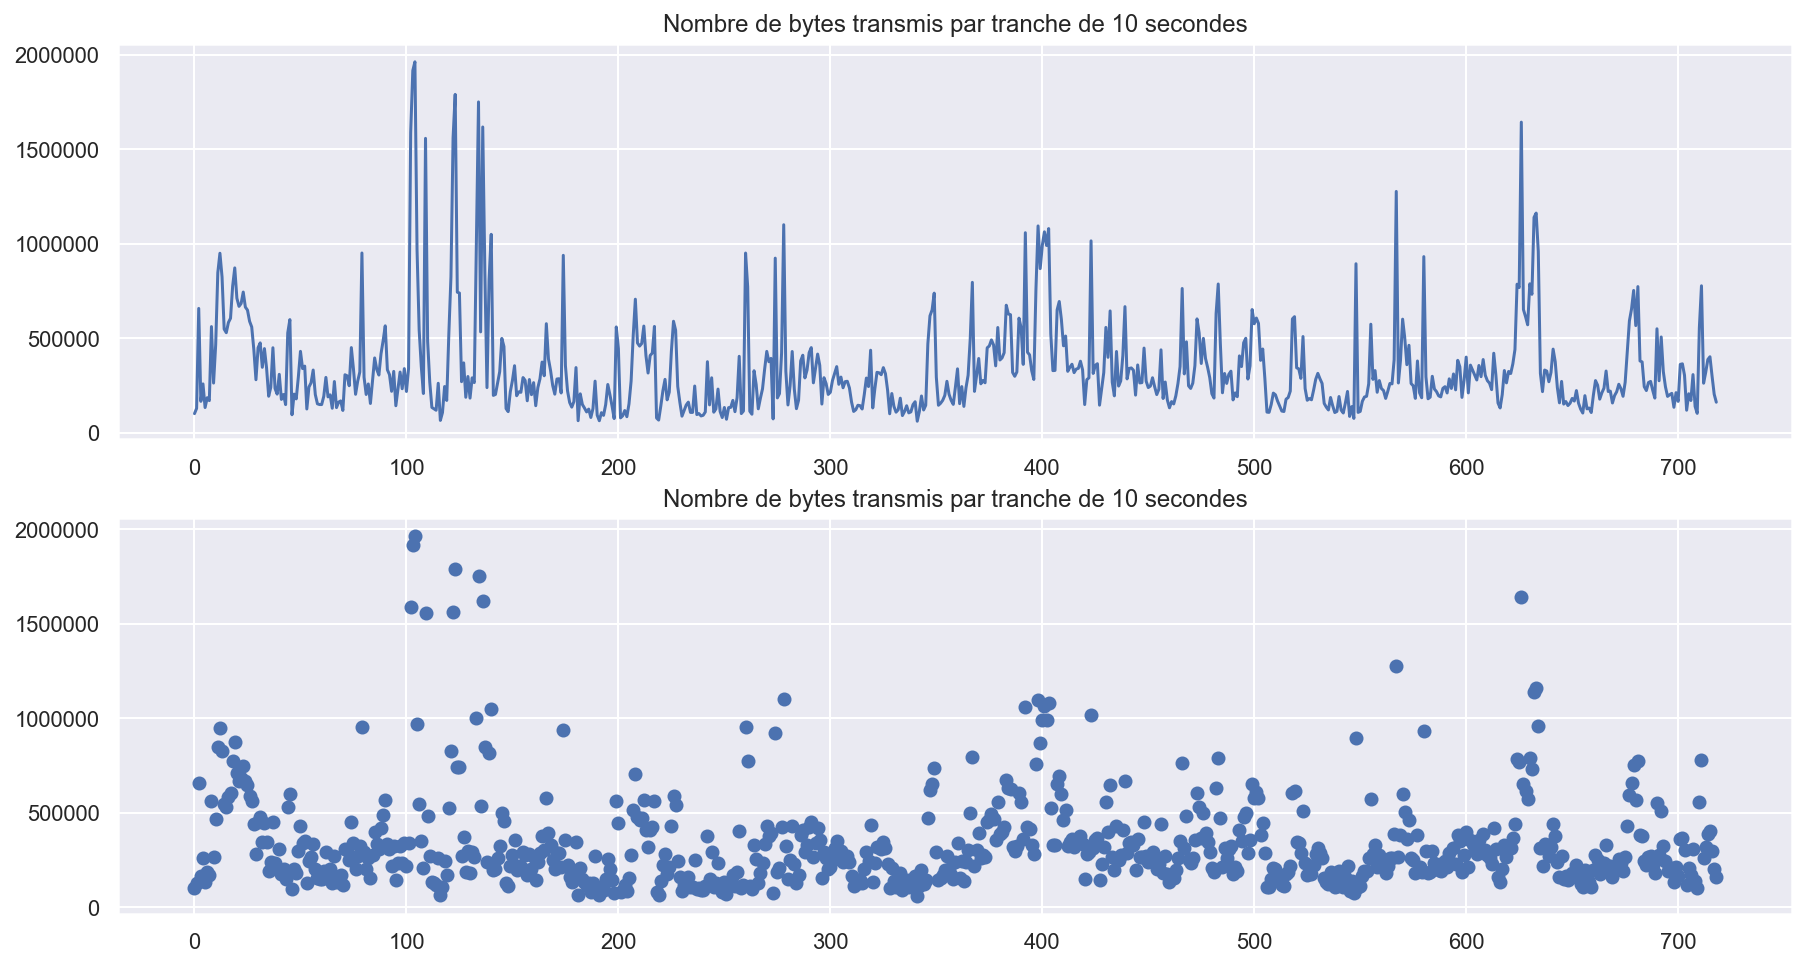

In [44]:
sns.set()
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(df_paquets['time'], df_paquets['bytes'])
plt.title("Nombre de bytes transmis par tranche de 10 secondes")
plt.subplot(2, 1, 2)
plt.title("Nombre de bytes transmis par tranche de 10 secondes")
plt.scatter(df_paquets['time'], df_paquets['bytes'])
plt.show()

<font style="color:Royalblue">
On voit sur le graphe que cette serie temporelle est stationnaire.
On peut utiliser le modèle y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub> avec d=0. 
    

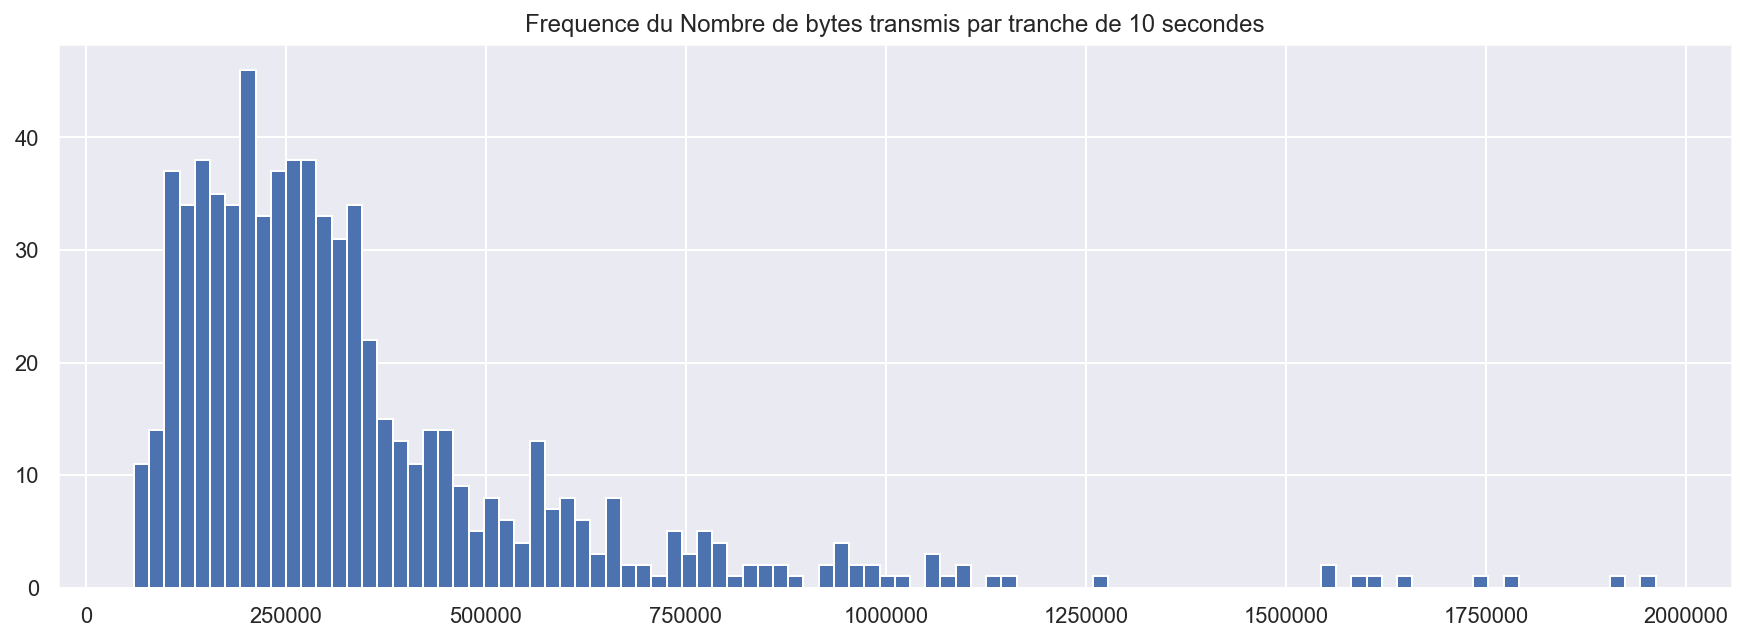

In [45]:
sns.set()
plt.figure(figsize=(15,5))
plt.hist( df_paquets['bytes'],bins=100)
plt.title("Frequence du Nombre de bytes transmis par tranche de 10 secondes")
plt.show()

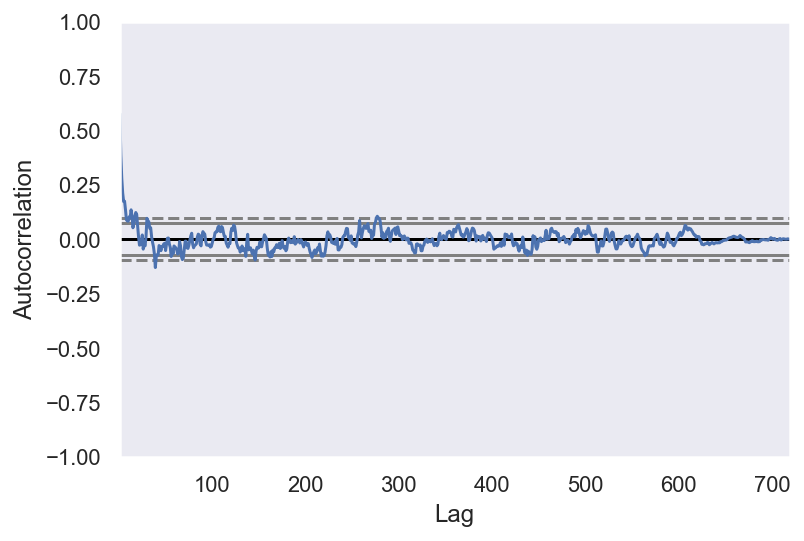

In [46]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_paquets['bytes'])

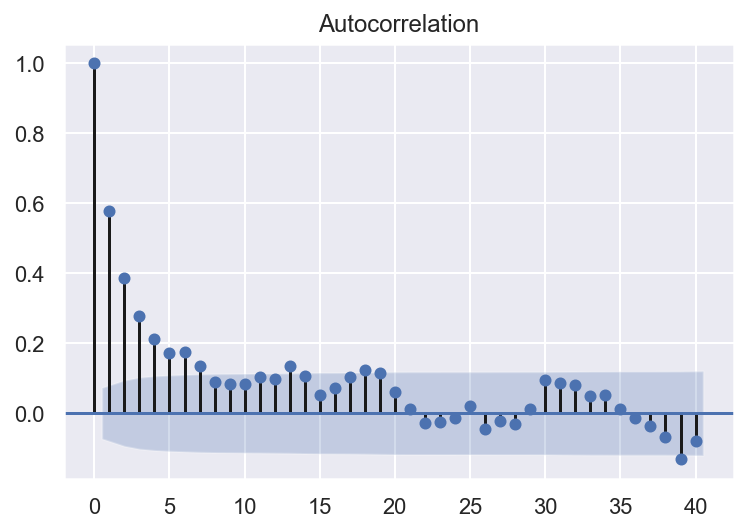

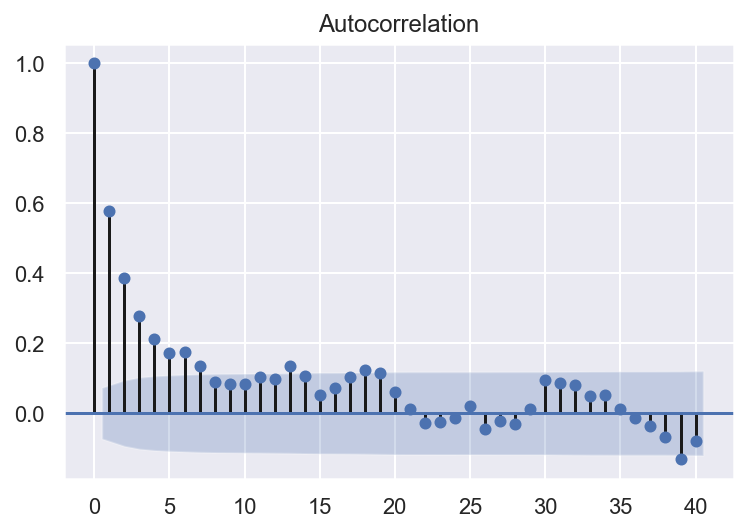

In [47]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_paquets['bytes'], lags=40)

<font style="color:Royalblue">
Nous pouvons voir qu'il existe une corrélation positive avec les 21 premiers lags, et le permiers 4 lags sont au dessus de 0.2.
 
Un bon point de départ pour le paramètre AR du modèle peut être 4.

9. Dans cette question on vous propose de construire un modèle auto-régressif AR(p). L’apprentissage
du modèle ne demande pas beaucoup de temps et s’effectue avec 1 − 2 ligne de code à l’aide
de la fonction ARIMA() importée de statsmodels.tsa.arima_model. Le choix du paramètre p
(d’une gamme de valeur prédéfinies, disons de 1 à pmax) est moins simple. On va aborder trois
possibilité : critère d’information d’Akaike (AIC), critère d’information bayésien (BIC) et validation
croisée/backtesting.

In [49]:
df_paquets.count()

bytes    719
time     719
dtype: int64

In [51]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import statsmodels.graphics.tsaplots as tsaplots

'''The parameters of the ARIMA model are defined as follows:
p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.'''
# Autocorrélation du permier lag est significatif.Un bon point de départ
# pour le paramètre p peut être 1.
# The data is stationary, no need difference ordre , so d = 0.

arima = ARIMA(df_paquets['bytes'].loc[:500], order=(4, 0, 0))
arima = arima.fit()
print(arima.summary())

                              ARMA Model Results                              
Dep. Variable:                  bytes   No. Observations:                  501
Model:                     ARMA(4, 0)   Log Likelihood               -6877.425
Method:                       css-mle   S.D. of innovations         221467.441
Date:                Sun, 26 Jan 2020   AIC                          13766.850
Time:                        22:05:56   BIC                          13792.149
Sample:                             0   HQIC                         13776.776
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.514e+05   2.62e+04     13.418      0.000       3e+05    4.03e+05
ar.L1.bytes     0.5522      0.045     12.372      0.000       0.465       0.640
ar.L2.bytes     0.0292      0.051      0.571    

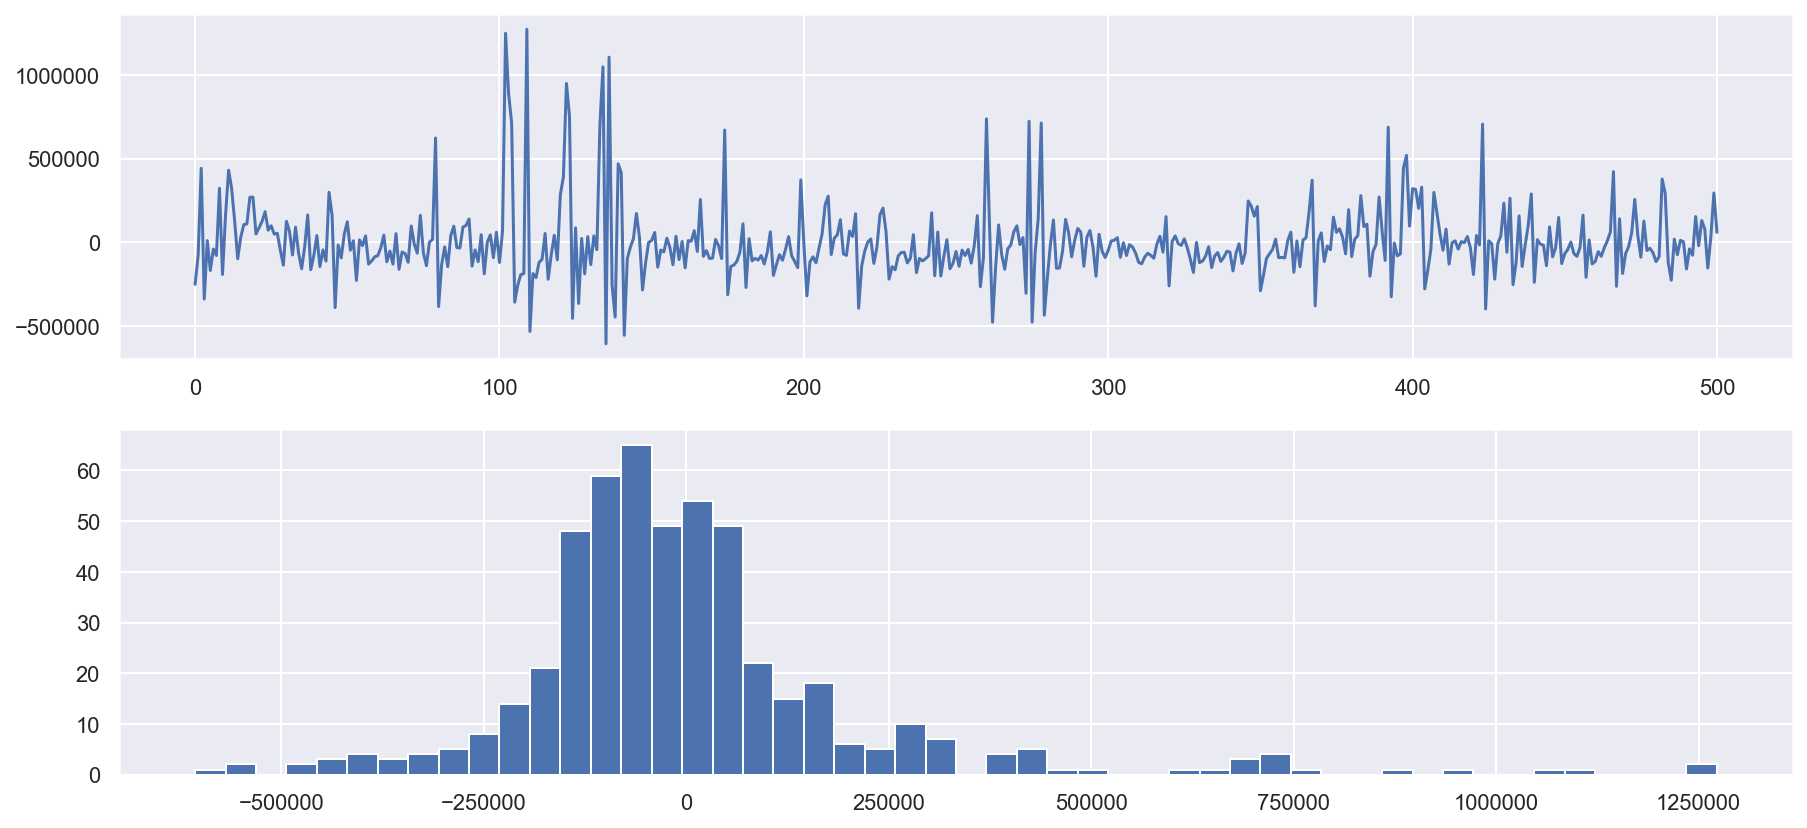

count    5.010000e+02
mean     3.513440e+02
std      2.217877e+05
min     -6.062925e+05
25%     -1.116478e+05
50%     -3.323118e+04
75%      5.858698e+04
max      1.272707e+06
dtype: float64


In [53]:
# plot residual errors
sns.set()
plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.plot(arima.resid)

plt.subplot(2, 1, 2)
plt.hist(arima.resid, bins=50)
plt.show()

print(arima.resid.describe())

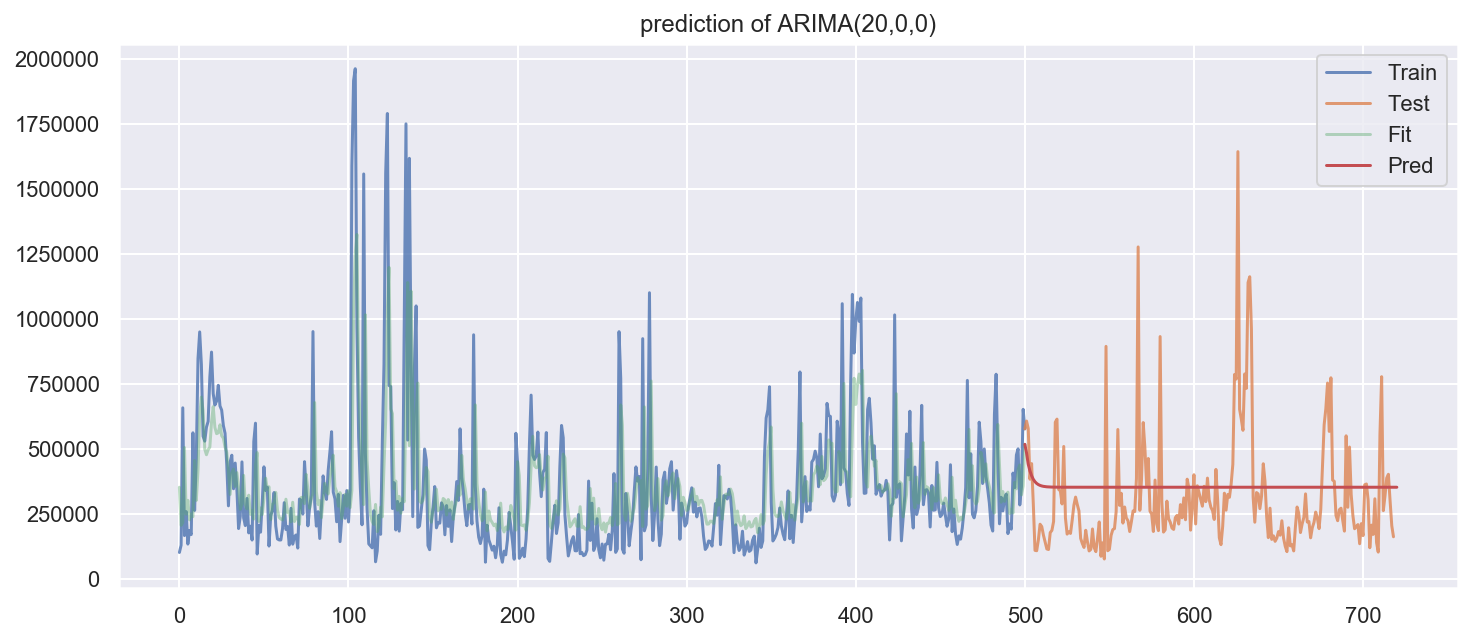

In [54]:
# plot the prediction of ARIMA(20,0,0)
plt.figure(figsize=(12, 5))
plt.plot(df_paquets['bytes'].loc[:500], label="Train", alpha=0.8)
plt.plot(df_paquets['bytes'].loc[500:], label="Test", alpha=0.8)
plt.plot(arima.predict(start=0, end=500), label="Fit", alpha=0.4)
plt.plot(arima.predict(start=500, end=720), label="Pred")
plt.title('prediction of ARIMA(20,0,0)')
plt.legend()
plt.show()

Le critères d’information AIC et BIC sont normalement implémentés dans le logiciel et sont donnés
directement après l’apprentissage du modèle. Pour faire la validation croisée pour une série, on la
coupe en nchunks chunks/folds et chaque fois utilise k premiers chunks pour entrainer le modèle et
le chunk numéro k + 1 pour le tester (par exemple regarder le risque quadratique). Pour une gamme de valeur choisie, effectue les trois méthodes de la sélection du modèle.

In [55]:
# Home made cross validation on time series,
# can also use scikit-learning sklearn.model_selection.TimeSeriesSplit
n_splits = 5
k = 0
mse_ts = []
total = len(df_paquets)
for i in range(1, n_splits):
    k = k + int(total/n_splits)
    ar = ARIMA(df_paquets['bytes'].loc[:k], order=(
        8, 0, 0))  # here put 8 to save time
    model_fit = ar.fit()

    print("TRAIN:1-", k, "   TEST:", k, "-", total)
    pred = model_fit.predict(start=k, end=total)
    mse_ts.append(mean_squared_error(pred, df_paquets['bytes'].loc[k-1:]))

TRAIN:1- 143    TEST: 143 - 719
TRAIN:1- 286    TEST: 286 - 719
TRAIN:1- 429    TEST: 429 - 719
TRAIN:1- 572    TEST: 572 - 719


In [56]:
print(mse_ts)
np.mean(mse_ts)

[60735072155.39088, 45010625429.01087, 42657761907.51631, 50221730977.072014]


49656297617.24752

10. En se basant sur les résultats de la question précédente, sélectionnez l’ordre p du modèle AR à
estimer et affichez les paramètres correspondants.
Tracez les résidus. Tracez l’estimation de la densité de résidus et la densité de la distribution
normale (avec moyenne et écart-type estimés) sur le même graphique et comparez les visuellement.
Commentez.

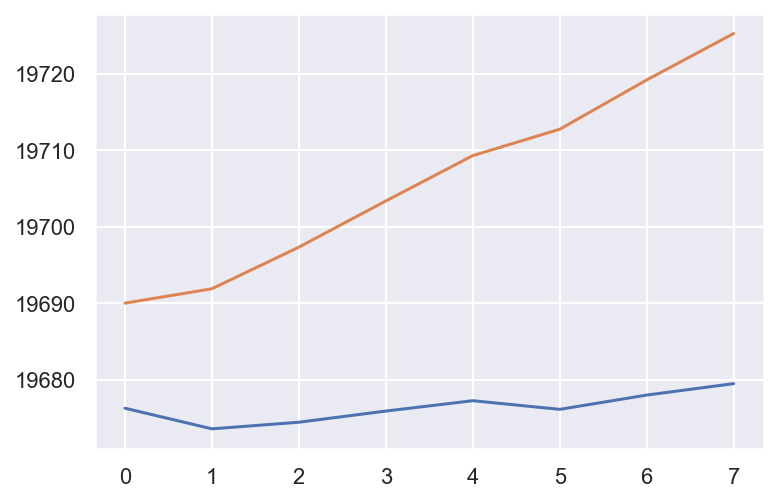

In [57]:
#choose p with AIC BIC
aic = []
bic = []
for p in range(1,9):
    
    ar = ARIMA(df_paquets['bytes'], order=(p,0,0)) 
    model_fit = ar.fit()
    aic.append(model_fit.aic) 
    bic.append(model_fit.bic) 

plt.plot(aic)
plt.plot(bic)

<font style="color:Royalblue">
With the best AIC, BIC value : p=1 

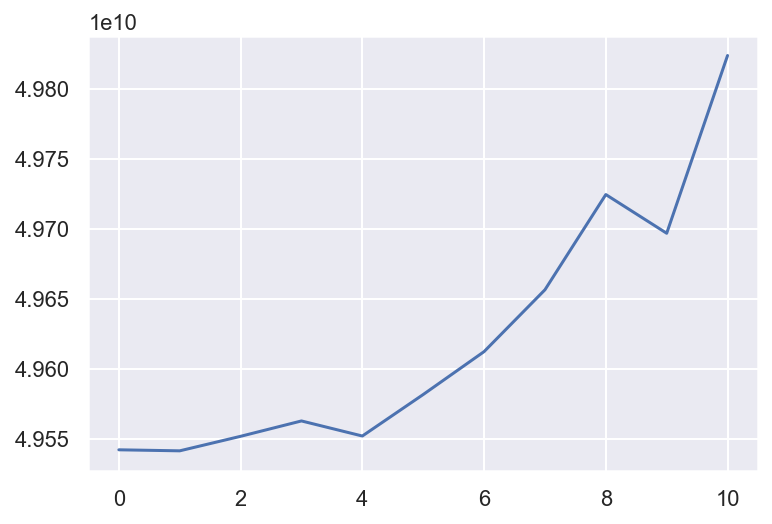

In [61]:
# cross validation to choose p
n_splits = 5
mse_ts_cv = []
for p in range(1, 12):
    k = 0
    mse_ts = []
    total = len(df_paquets)
    for i in range(1, n_splits):
        k = k + int(total/n_splits)
        # try different p
        ar = ARIMA(df_paquets['bytes'].loc[:k], order=(p, 0, 0))
        model_fit = ar.fit()
        pred = model_fit.predict(start=k, end=total)
        mse = mean_squared_error(pred, df_paquets['bytes'].loc[k-1:])
        mse_ts.append(mse)
        # print("TRAIN:1-", k, "   TEST:", k,"-", total,"mse:",mse)
    mse_ts_cv.append(np.mean(mse_ts))

plt.plot(mse_ts_cv)
plt.show()

<font style="color:Royalblue">
With the best MSE value using forward valitation: p=1 

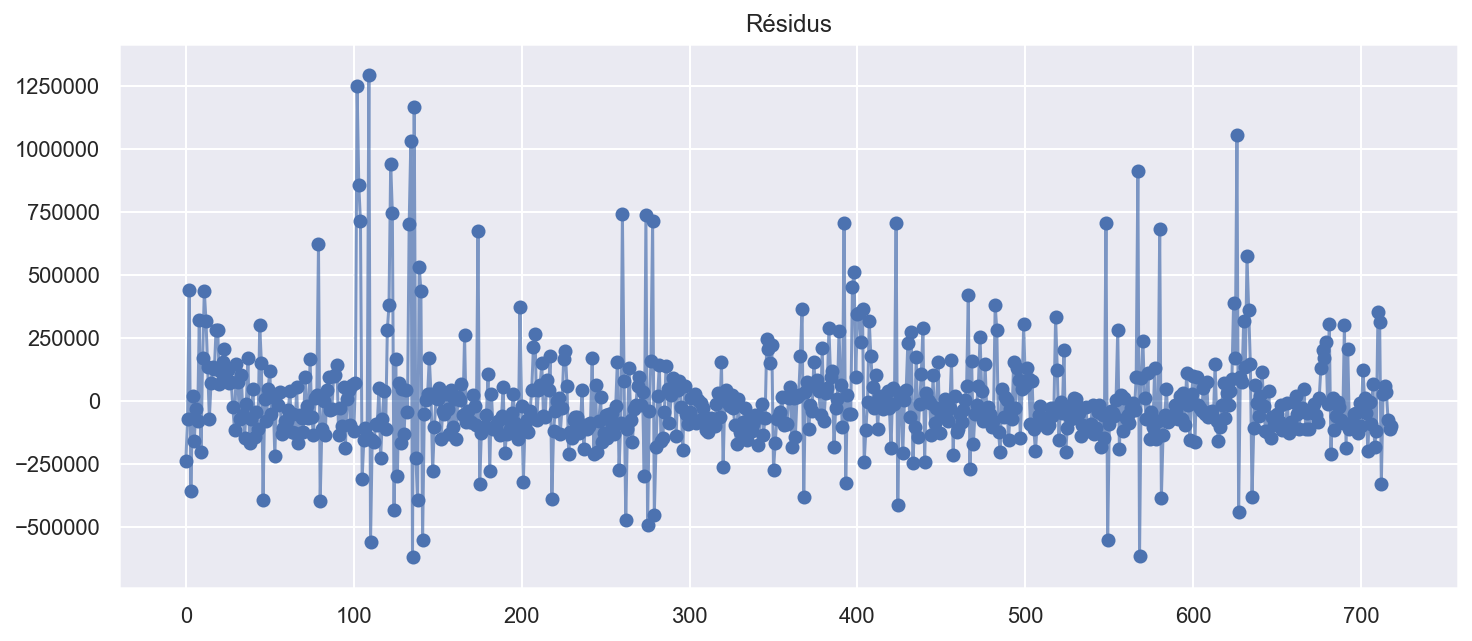

In [62]:
arima = ARIMA(df_paquets['bytes'], order=(1,0,0))
arima = arima.fit()

# plot residual errors
plt.figure(figsize=(12,5))
plt.plot(arima.resid,alpha=0.7)
plt.scatter(df_paquets['time'],arima.resid)
plt.title('Résidus')
plt.show()

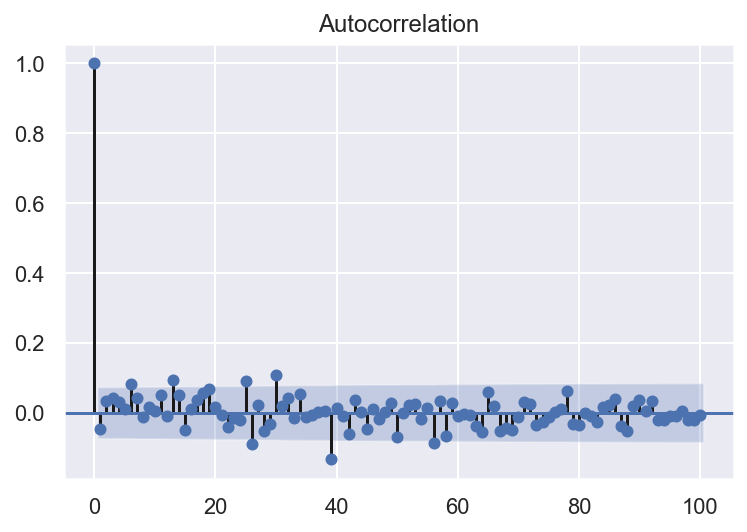

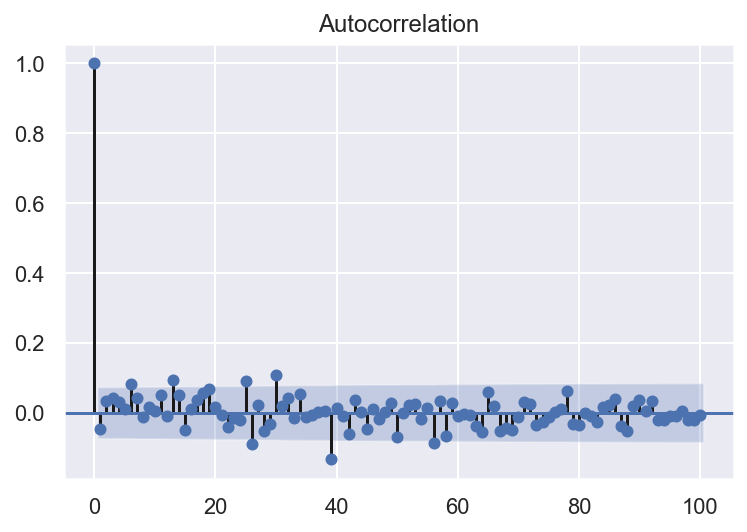

In [63]:
plot_acf(arima.resid, lags = 100)

In [64]:
arima.resid.describe()

count    7.190000e+02
mean    -1.433404e+02
std      2.112230e+05
min     -6.210341e+05
25%     -1.021981e+05
50%     -3.566584e+04
75%      5.537745e+04
max      1.294551e+06
dtype: float64

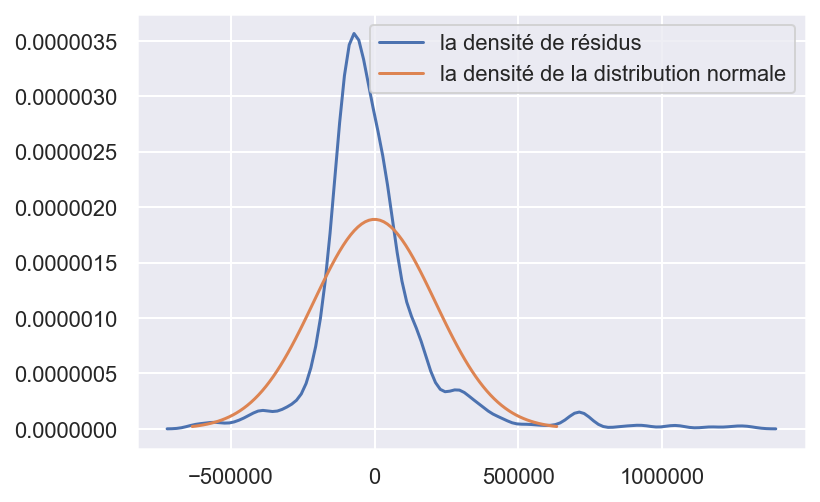

In [65]:
sns.set()
plt.figure()

sns.kdeplot(arima.resid, label='la densité de résidus')
# plt.hist(arima.resid,density=True,histtype='step',bins=100)

mu = np.mean(arima.resid)
variance = np.var(arima.resid)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# (avec moyenne et écart-type estimés)
plt.plot(x, stats.norm.pdf(x, mu, sigma),
         label='la densité de la distribution normale')
plt.legend(loc='upper right')
plt.show()

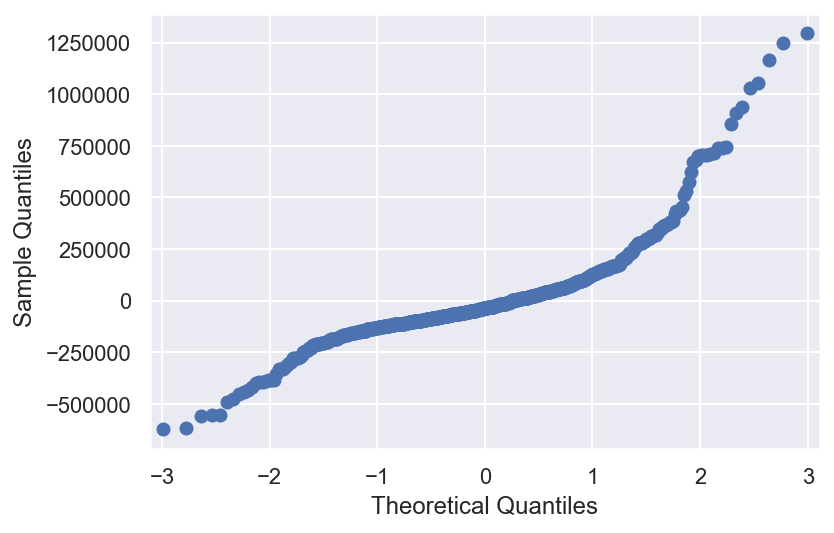

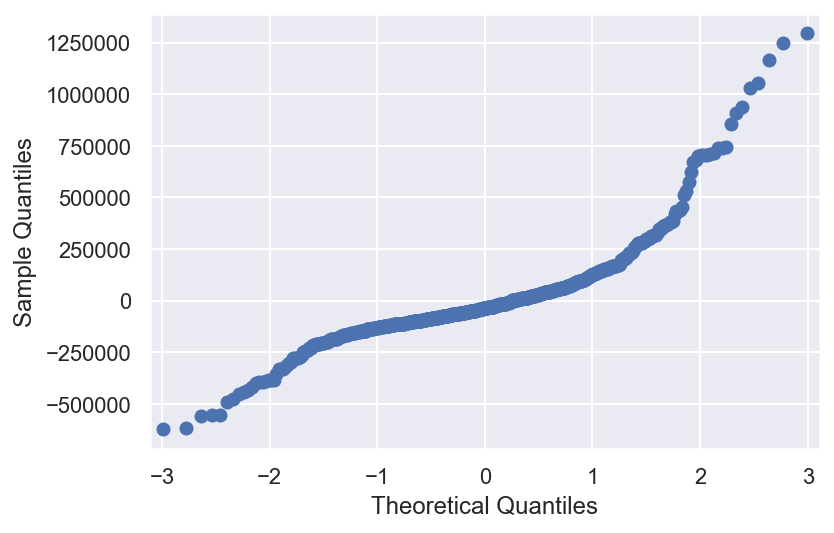

In [66]:
from statsmodels.graphics.gofplots import qqplot
qqplot(arima.resid)

<font style="color:Royalblue">
Les résidus sont utiles pour vérifier si un modèle a correctement saisi les informations dans les données. Le modèle ARIMA(1,0,0) est plutôt bien cars il donne des résidus avec les propriétés suivantes:

* Les résidus ne sont pas corrélés: il ne reste plus d'informations dans les résidus qui devraient être utilisées dans le calcul des prévisions.
* Les résidus ont une moyenne presque nulle(petit skewness). Les prévisions sont très légerement biaisées.
* Les résidus sont distribué selon une lois non-Gaussien (kurtosis non null), le modèle ne fit pas parfaitement les données (non-linéaire).

# Données “Southern Oscillation Index” 

11. Importez les données du fichier soi.tsv. Consultez http://www.bom.gov.au/climate/glossary/soi.shtml pour plus d’information sur les données. Supprimez les données manquantes.

In [67]:
df3 = pd.read_csv("soi.tsv", delimiter="\t", header=None).T
df3.head()

0
0  1.537160
1  0.922168
2 -0.104204
3 -0.291903
4 -0.658745

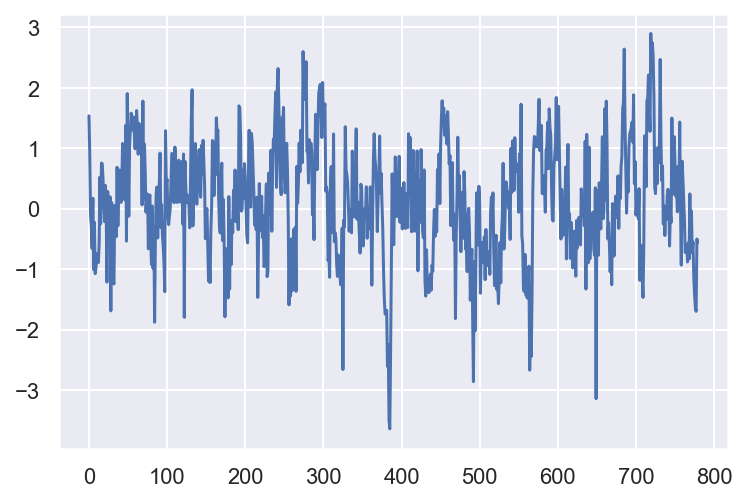

In [68]:
plt.plot(df3)

In [232]:
df3.describe()

0
count  780.000000
mean     0.126377
std      0.947513
min     -3.644050
25%     -0.482882
50%      0.134003
75%      0.761842
max      2.899500

In [69]:
df3 = df3.dropna()

12. A l’aide des fonctions plot_acf() et plot_pacf() importées de statsmodels.graphics.tsaplots,
tracez la fonction d’autocorrélation et la fonction d’autocorrélation partielle.

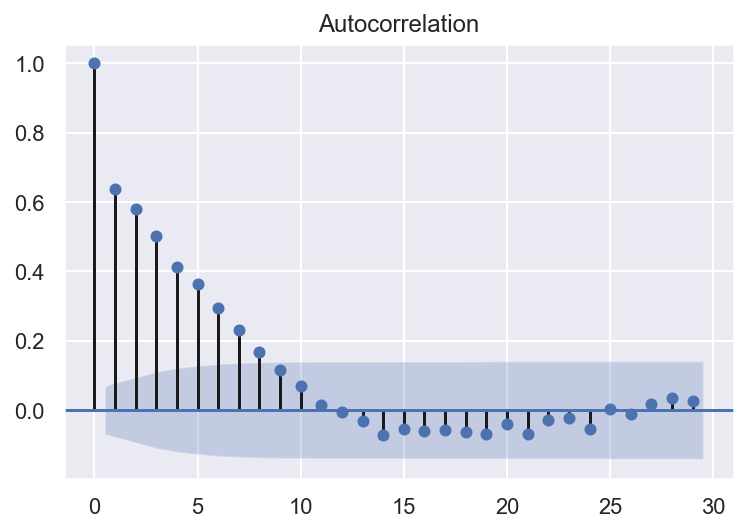

In [70]:
tsa.plot_acf(df3)

<font style="color:Royalblue">
L'autorrelation partielle est significative jusqu'à environ un ordre de 11. 

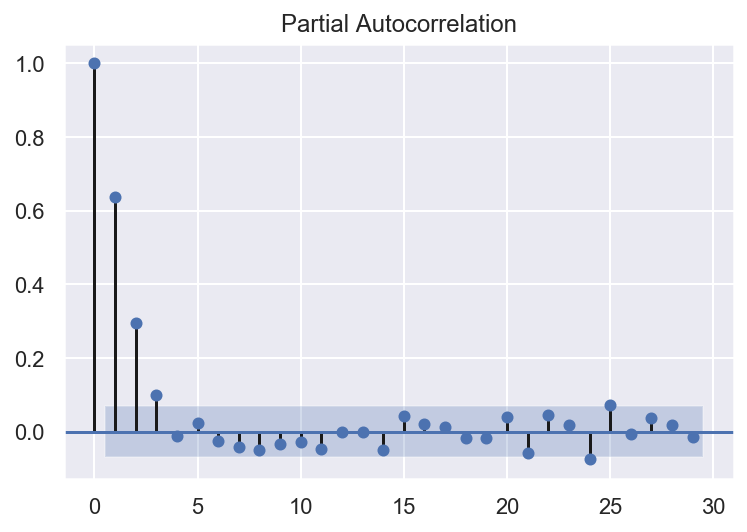

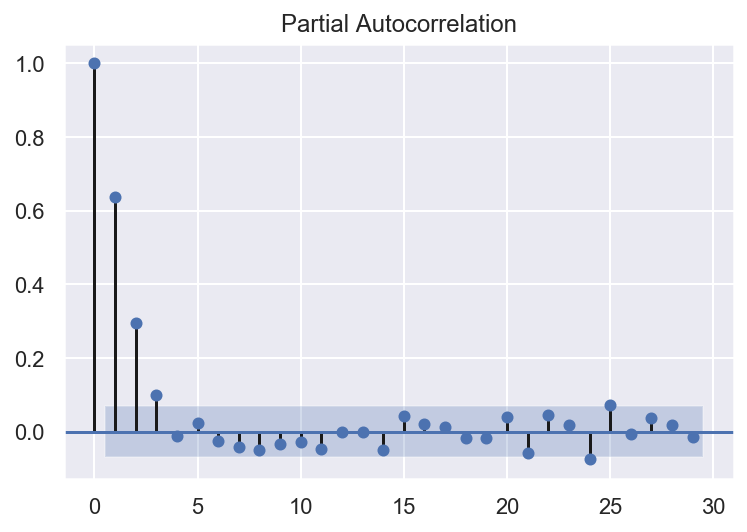

In [71]:
tsa.plot_pacf(df3)

13. En se basant sur la question précédente, choisissez l’ordre du processus auto-régressive AR(p).
Entrainer le modèle AR choisi.

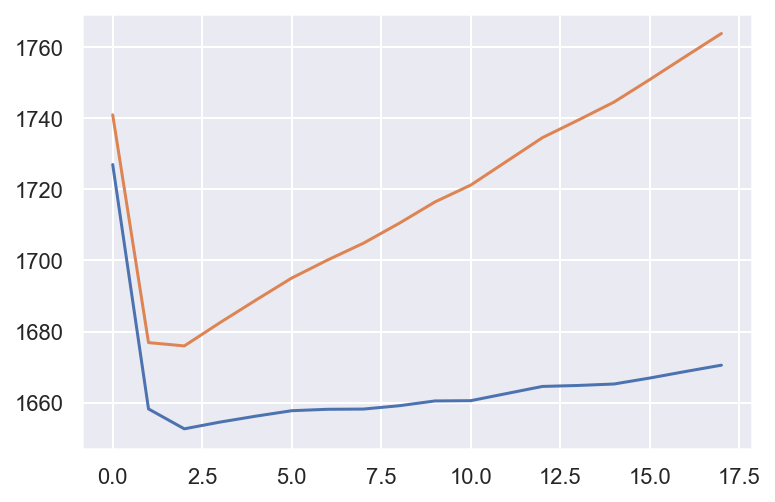

In [73]:
aic = []
bic = []
for p in range(1, 19):

    ar = ARMA(df3, order=(p, 0))
    model_fit = ar.fit()
    aic.append(model_fit.aic)
    bic.append(model_fit.bic)

plt.plot(aic)
plt.plot(bic)

<font style="color:Royalblue">
Le meilleur p=2.

In [74]:
ar = ARMA(df3, order=(2,0)) 
arma3 = ar.fit()
arma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      0   No. Observations:                  780
Model:                     ARMA(2, 0)   Log Likelihood                -825.133
Method:                       css-mle   S.D. of innovations              0.697
Date:                Sun, 26 Jan 2020   AIC                           1658.265
Time:                        22:19:05   BIC                           1676.903
Sample:                             0   HQIC                          1665.434
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1293      0.097      1.328      0.184      -0.061       0.320
ar.L1.0        0.4507      0.034     13.175      0.000       0.384       0.518
ar.L2.0        0.2945      0.034      8.603      0.000       0.227       0.362
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2302           +0.0000j            1.2302            0.0000
AR.2           -2.7607           +0.0000j            2.7607            0.5000
-----------------------------------------------------------------------------
"""

Tracez les résidus. Tracez l’estimation de la densité de résidus et la
densité de la distribution normale (avec moyenne et écart-type estimés) sur le même graphique et
comparez les visuellement. Commentez.

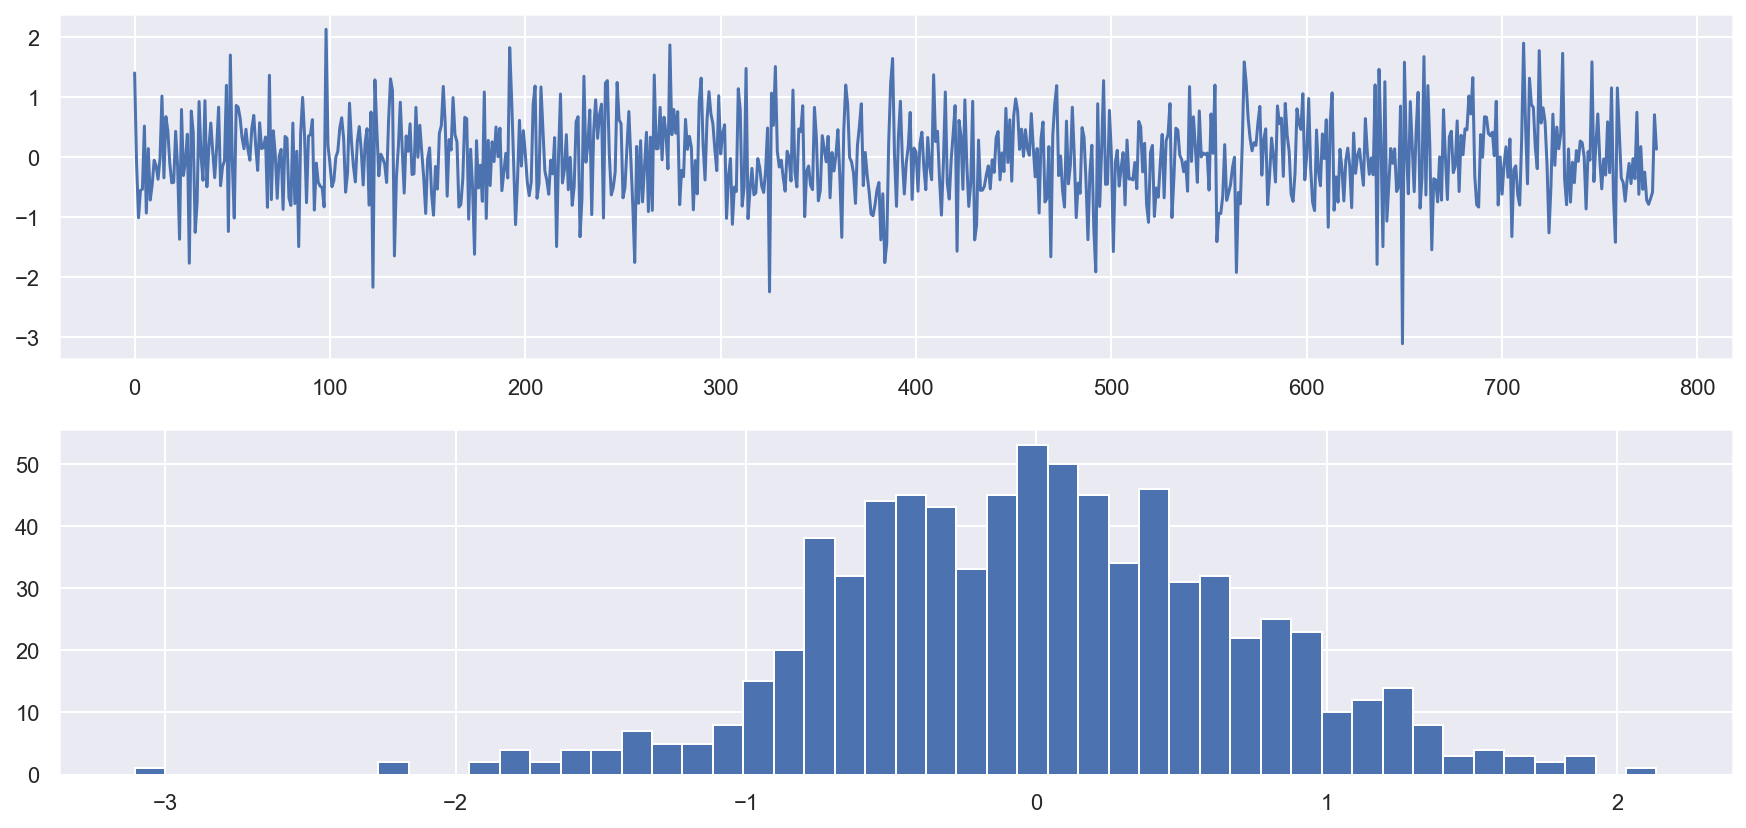

count    780.000000
mean      -0.001984
std        0.697894
min       -3.106289
25%       -0.479254
50%        0.001980
75%        0.450405
max        2.136042
dtype: float64


In [75]:
# plot residual errors
sns.set()
plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.plot(arma3.resid)

plt.subplot(2, 1, 2)
plt.hist(arma3.resid, bins=50)
plt.show()

print(arma3.resid.describe())

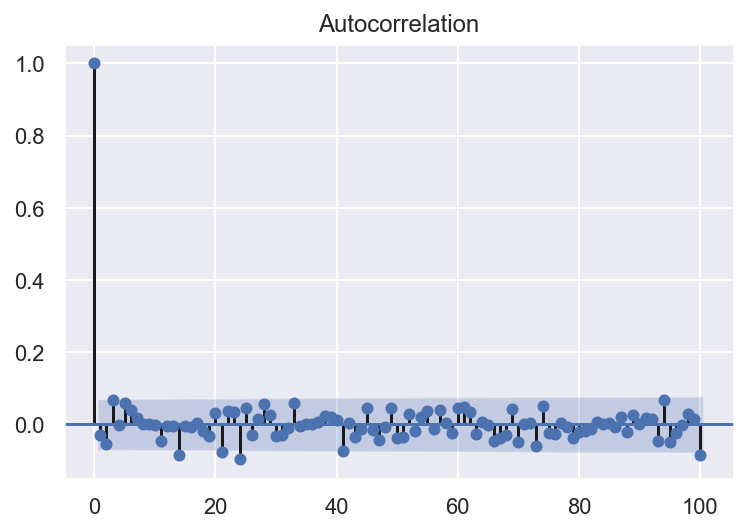

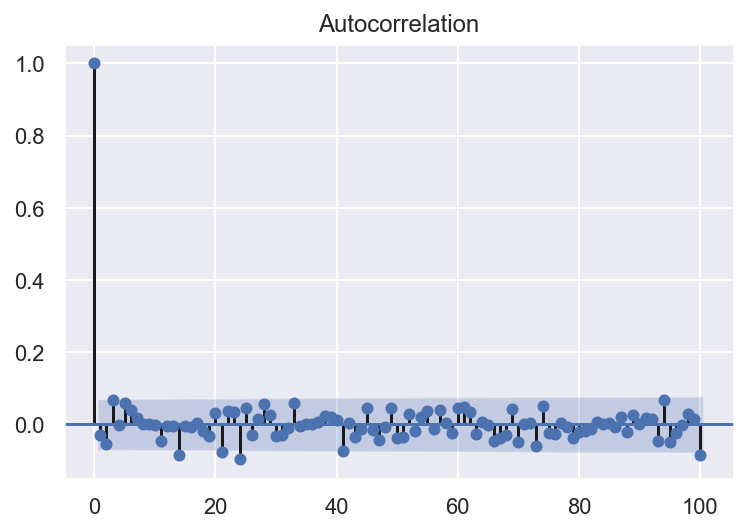

In [76]:
plot_acf(arma3.resid, lags=100)

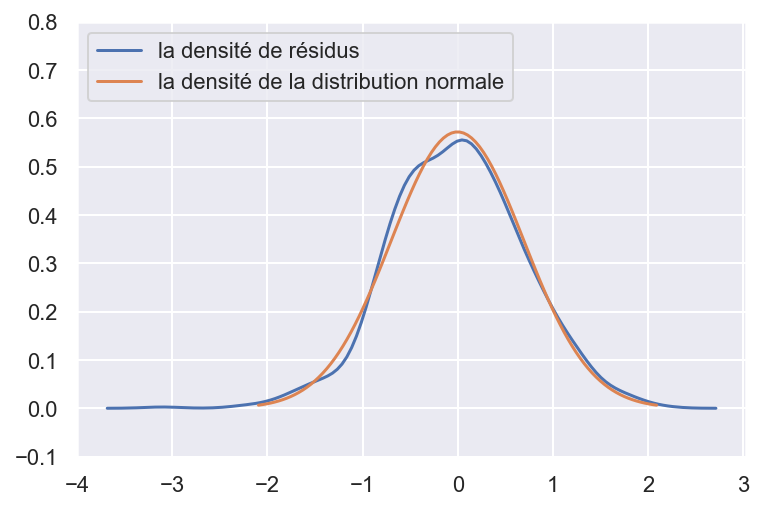

In [78]:
sns.set()
plt.figure()

sns.kdeplot(arma3.resid, label='la densité de résidus')
# plt.hist(arima.resid,density=True,histtype='step',bins=100)

mu = np.mean(arma3.resid)
variance = np.var(arma3.resid)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# (avec moyenne et écart-type estimés)
plt.plot(x, stats.norm.pdf(x, mu, sigma),
         label='la densité de la distribution normale')
plt.ylim(-0.1,0.8)
plt.legend(loc='upper left')
plt.show()

<font style="color:Royalblue">
Les résidus sont distribués selon une loi normale. Les résidus ne sont pas autocorrélés. Le modèle ARMA(2,0) est satisfaisant.

14. Tracez le périodogramme ; superposez le à la densité spectrale du modèle estimé à la question
précédente. On utilisera qu’un modèle AR(p) de coefficients auto-régressifs φ1, . . . , φp satisfaisant
l’équation AR

Text(0.5, 1.0, 'la densité spectrale du modèle estimé à la question précédente')

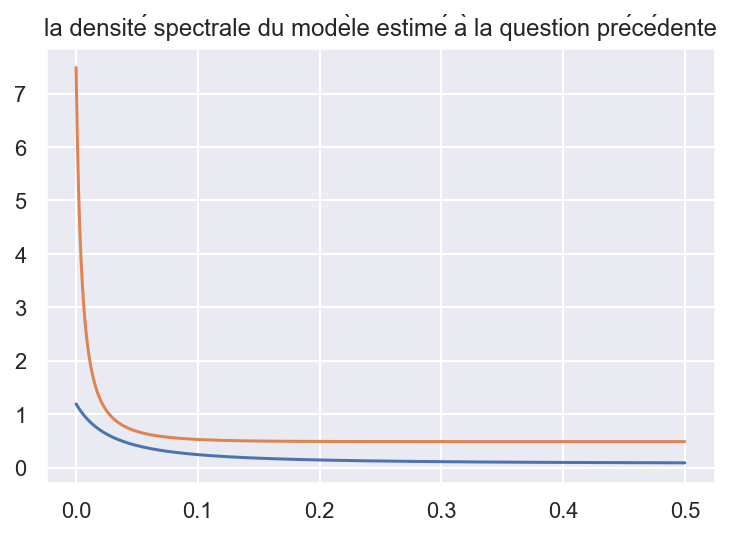

In [98]:
#la densité spectrale
x = np.linspace(0, 0.5, 1000)
sd = (np.var(arma3.resid)/(2*np.pi))*1 / \
    (1-(arma3.arparams[0]*np.exp((-1)*i*x) +
        arma3.arparams[1]*np.exp((-2)*i*x)))**2
sd2 = (np.var(arma3.resid))*1 / \
    (1-(arma3.arparams[0]*np.exp(2*np.pi*(-1)*i*x) +
        arma3.arparams[1]*np.exp(2*np.pi*(-2)*i*x)))**2
plt.plot(x,sd)
plt.plot(x,sd2)
plt.title('la densité spectrale du modèle estimé à la question précédente')

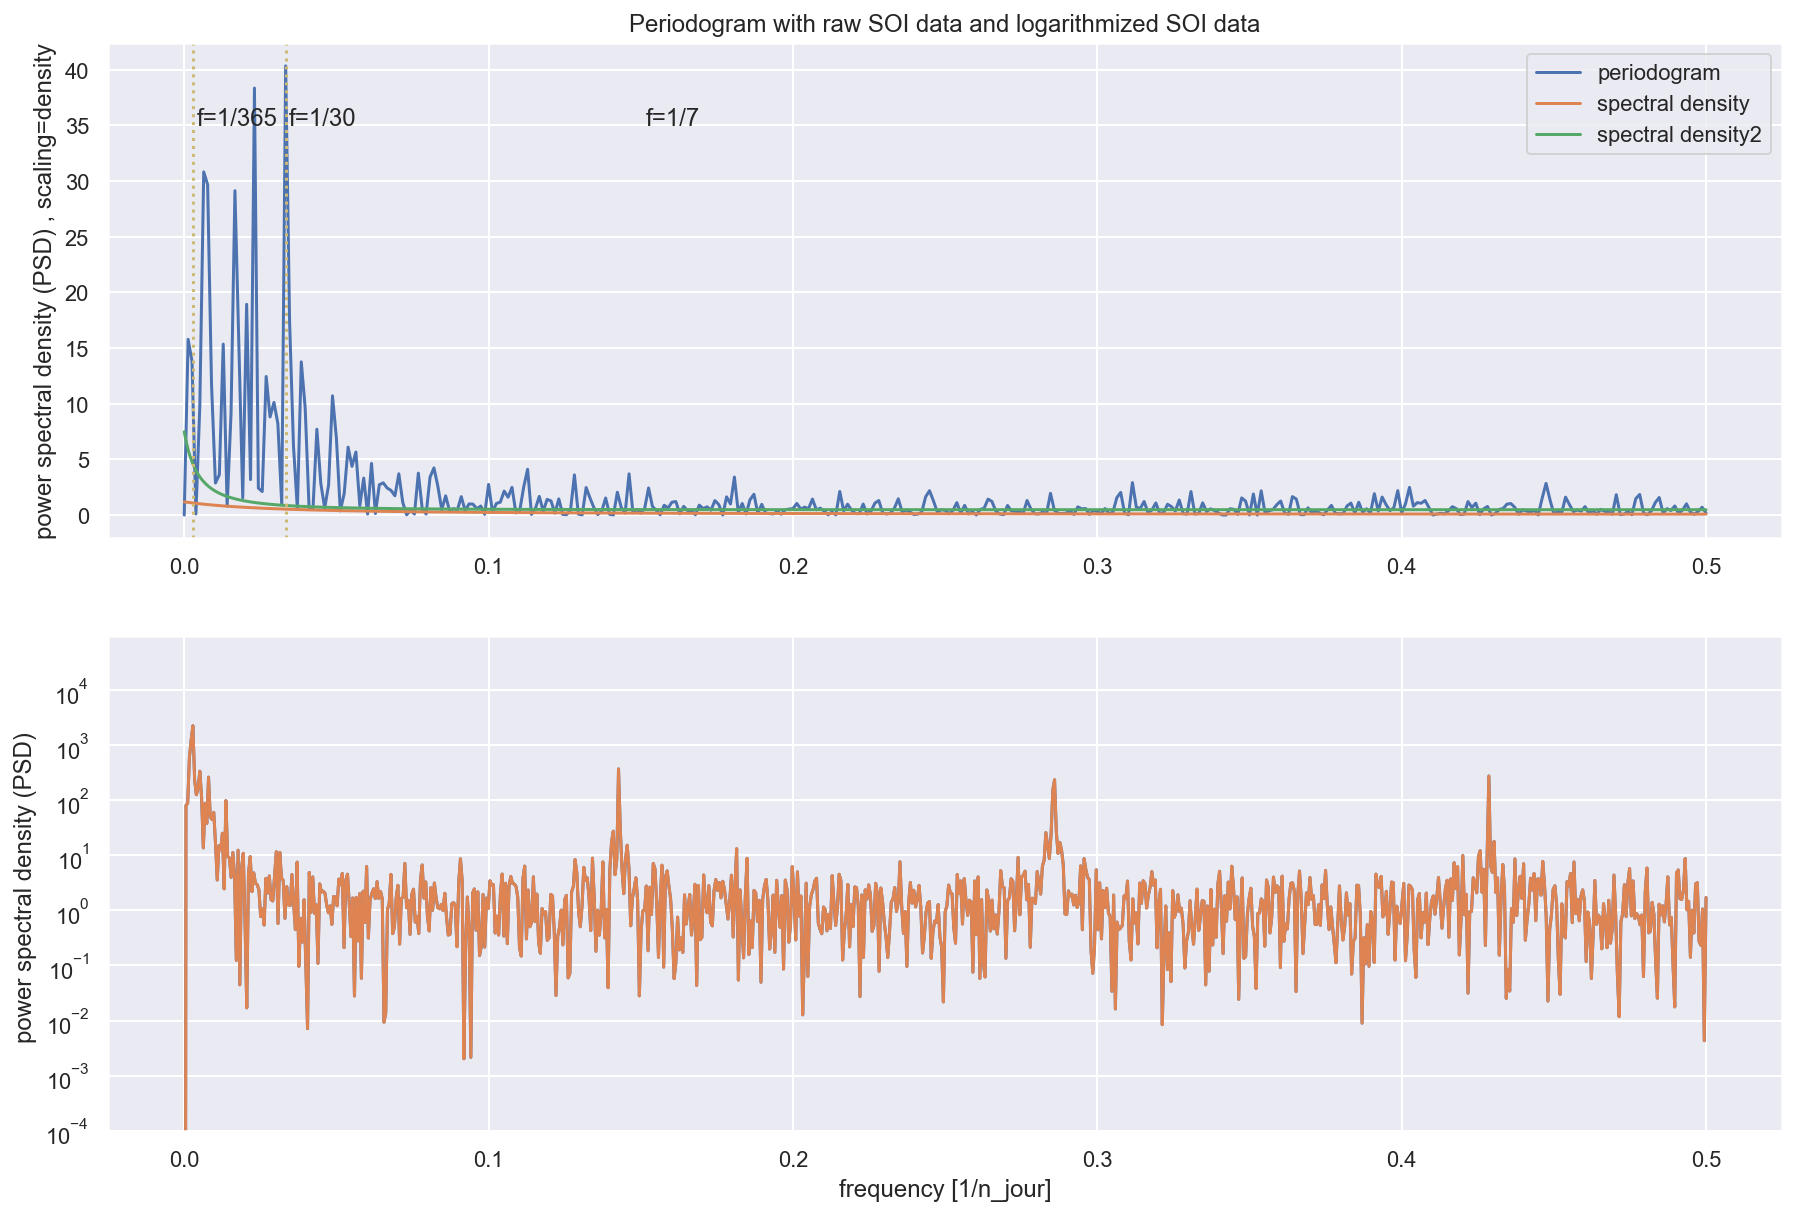

In [99]:
sns.set()
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)

# calcul the spectral density using the formule
x = np.linspace(0, 0.5, 1000)
sd = (np.var(arma3.resid)/(2*np.pi))*1 / \
    (1-(arma3.arparams[0]*np.exp((-1)*i*x) +
        arma3.arparams[1]*np.exp((-2)*i*x)))**2
sd2 = (np.var(arma3.resid))*1 / \
    (1-(arma3.arparams[0]*np.exp(2*np.pi*(-1)*i*x) +
        arma3.arparams[1]*np.exp(2*np.pi*(-2)*i*x)))**2


# f : ndarray : Array of sample frequencies.
# Pxx : ndarray :Power spectral density or power spectrum of x.
f, Pxx_den = signal.periodogram(df3[0], scaling='density')
plt.plot(f, Pxx_den, label='periodogram')
plt.plot(x, sd, label='spectral density')
plt.plot(x, sd2, label='spectral density2')
plt.axvline(x=1/365, c='y', linestyle=':')
plt.axvline(x=1/30, c='y', linestyle=':')
#plt.axvline(x=1/7, c='y', linestyle=':')
plt.text(1/29, 35, 'f=1/30')
plt.text(1/250, 35, 'f=1/365')
plt.text(1/6.6, 35, 'f=1/7')
plt.legend()
# plt.xlabel('frequency')

plt.ylabel('power spectral density (PSD) , scaling=density')
plt.title('Periodogram with raw SOI data and logarithmized SOI data')

plt.subplot(2, 1, 2)
f, Pxx_den = signal.periodogram(np.log(df['IAS_brut']), scaling='density')
plt.plot(f, Pxx_den)
# This is just a thin wrapper around plot which additionally changes the y-axis to log scaling.
plt.semilogy(f, Pxx_den)
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.semilogy.html
plt.ylim(10e-5,)
plt.xlabel('frequency [1/n_jour]')
plt.ylabel('power spectral density (PSD) ')
plt.show()